In [1]:
import os
import torch
import copy
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import r2_score, mean_squared_error

def fix_random(seed: int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

fix_random(42)

# check if tabular ML folder exists
if not os.path.exists('tabularML'):
    os.makedirs('tabularML')

In [2]:
df = pd.read_csv('dataset.csv')

# PyTorch Device
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print('Using device:', device)

Using device: mps


In [3]:
X = df.drop('rating', axis=1)
Y = df['rating']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

Y_train = Y_train.to_numpy()
Y_val = Y_val.to_numpy()
Y_test = Y_test.to_numpy()

Y_train = Y_train.reshape(-1, 1)
Y_val = Y_val.reshape(-1, 1)

print(f'Number of training samples: {X_train.shape[0]}')
print(f'Number of validation samples: {X_val.shape[0]}')
print(f'Number of testing samples: {X_test.shape[0]}')
print(f'\nNumber of features: {X_train.shape[1]}')

Number of training samples: 9946
Number of validation samples: 1106
Number of testing samples: 2764

Number of features: 1128


In [4]:
# hyperparameters
nums_epochs = [200]
batch_sizes = [32,64,128]
patience = [10]
n_d_a = [16,32,64]
n_shared = [2,3]
n_indipendent = [2,3]
n_step = [6,7]
gamma = [1.3]
epsilon = [1e-8]

hyperparameters = itertools.product(n_d_a, n_step,n_indipendent,n_shared, gamma, epsilon,nums_epochs, batch_sizes)
n_comb = len(n_d_a)*len(n_step)*len(n_indipendent)*len(n_shared)*len(gamma)*len(epsilon)*len(nums_epochs)*len(batch_sizes)
print (f'Number of hyperparameter combinations: {n_comb}')

Number of hyperparameter combinations: 72


In [5]:
def get_model(n_d_a, n_step,n_indipendent,n_shared, gamma, epsilon):
    model = TabNetRegressor(
        # n_d: the dimensionality of the output space of the feature transformer network (default 64)
        n_d=n_d_a,
        # n_a: the dimensionality of the output space of the attention network (default 64)
        n_a=n_d_a,
        # n_steps: the number of sequential steps in the attention mechanism (default 3)
        n_steps=n_step,
        # gamma: the scaling factor for the feature transformer network (default 1.3)
        gamma=gamma,
        # optimizerm name of optimizer to use (default Adam)
        optimizer_fn=torch.optim.Adam,
        # n_independent: the number of independent feature transformer networks to use (default 2)
        n_independent=n_indipendent,
        # n_shared: the number of shared feature transformer networks to use (default 2)
        n_shared=n_shared,
        # epsilon: a small value to add to the denominator of the feature importance calculation to avoid division by zero (default 1e-15)
        epsilon=epsilon,
        # seed: the random seed to use for reproducibility (default None)
        seed=42    
    )
    return model

In [6]:
if os.path.exists('tabularML/training'):
    os.system('rm -r tabularML/training')
else:
    os.makedirs('tabularML/training')

current_iter = 0

best_mse = float('inf')
best_model = None
best_n_d = None
best_n_a = None
best_n_step = None
best_n_indipendent = None
best_n_shared = None
best_gamma = None
best_batch_size = None

for n_d_a, n_step,n_indipendent,n_shared, gamma, epsilon,nums_epochs, batch_sizes in hyperparameters:
    current_iter += 1

    print("\nIterations {}/{} - Hyperparameters:  batch_sizes={}, nums_epochs={}, n_d={}, n_a={}, n_step={}, n_indipendent={}, n_shared={}, gamma={}, epsilon={}".format(
        current_iter, n_comb, batch_sizes, nums_epochs, n_d_a, n_d_a, n_step, n_indipendent, n_shared, gamma, epsilon ))

    model = get_model(n_d_a, n_step, n_indipendent, n_shared, gamma, epsilon)
    
    log_name = "batch_size:"+str(batch_sizes)+"n_d:"+str(n_d_a)+"n_a:"+str(n_d_a)+"n_step:"+str(n_step)+"n_indipendent:"+str(n_indipendent)+"n_shared:"+str(n_shared)+"gamma:"+str(gamma)+"epsilon:"+str(epsilon)
    
    # start tensorboard
    writer = SummaryWriter('tabularML/training/'+log_name)
    
    # train
    model.fit(
                X_train=X_train,
                y_train=Y_train,
                eval_set=[(X_val, Y_val)],
                eval_metric=['mse'],
                # patience: the number of epochs to wait without improvement in validation loss before early stopping (default 10)
                patience=10,
                # batch_size: the number of samples per batch (default 1024)
                batch_size=batch_sizes,
                # virtual_batch_size: the number of samples per virtual batch (default 128)
                virtual_batch_size=128,
                # num_workers: the number of worker processes to use for data loading (default 0)
                num_workers=0,
                # drop_last: whether to drop the last incomplete batch if the dataset size is not divisible by the batch size (default False)
                drop_last=False,
                # max_epochs: the maximum number of epochs to train for (default 100)
                max_epochs=nums_epochs,
            )
    

    preds = model.predict(X_test)
    mse = mean_squared_error(Y_test, preds)
    
    writer.add_hparams({'n_d':n_d_a, 'n_a':n_d_a, 'n_step':n_step, 'n_indipendent':n_indipendent, 'n_shared':n_shared, 'gamma':gamma, 'epsilon':epsilon, 'batch_sizes':batch_sizes, 'nums_epochs':nums_epochs }, {'hparam/mse': mse})

    if mse < best_mse:
        best_mse = mse
        best_n_d = n_d_a
        best_n_a = n_d_a
        best_n_step = n_step
        best_n_indipendent = n_indipendent
        best_n_shared = n_shared
        best_gamma = gamma
        best_batch_size = batch_sizes
        best_model = copy.deepcopy(model) 
        
    writer.flush()            
            
    print("Model MSE: {:.6f} - Best MSE: {:.6f}".format(mse, best_mse))
    print("Model R2 Score: {:.6f} - Best R2 Score: {:.6f}".format(r2_score(Y_test, preds), r2_score(Y_test, best_model.predict(X_test))))



Iterations 1/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00997 | val_0_mse: 0.24733 |  0:00:25s
epoch 1  | loss: 0.15776 | val_0_mse: 0.09191 |  0:00:49s
epoch 2  | loss: 0.10763 | val_0_mse: 0.07695 |  0:01:13s
epoch 3  | loss: 0.08941 | val_0_mse: 0.06675 |  0:01:37s
epoch 4  | loss: 0.08342 | val_0_mse: 0.06043 |  0:02:01s
epoch 5  | loss: 0.08122 | val_0_mse: 0.08044 |  0:02:25s
epoch 6  | loss: 0.08239 | val_0_mse: 0.05855 |  0:02:48s
epoch 7  | loss: 0.06124 | val_0_mse: 0.04539 |  0:03:12s
epoch 8  | loss: 0.04985 | val_0_mse: 0.09366 |  0:03:35s
epoch 9  | loss: 0.03844 | val_0_mse: 0.03029 |  0:04:00s
epoch 10 | loss: 0.04035 | val_0_mse: 0.05782 |  0:04:23s
epoch 11 | loss: 0.06321 | val_0_mse: 0.06593 |  0:04:49s
epoch 12 | loss: 0.04534 | val_0_mse: 0.09602 |  0:05:13s
epoch 13 | loss: 0.03425 | val_0_mse: 0.06167 |  0:05:36s
epoch 14 | loss: 0.02985 | val_0_mse: 0.02868 |  0:06:00s
epoch 15 | loss: 0.03722 | val_0_mse: 0.03081 |  0:06:24s
epoch 16 | loss: 0.03283 | val_0_mse: 0.02466 |  0:06:47s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.011893 - Best MSE: 0.011893
Model R2 Score: 0.946349 - Best R2 Score: 0.946349

Iterations 2/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.7093  | val_0_mse: 0.37873 |  0:00:14s
epoch 1  | loss: 0.15427 | val_0_mse: 0.07799 |  0:00:28s
epoch 2  | loss: 0.12662 | val_0_mse: 0.06026 |  0:00:42s
epoch 3  | loss: 0.07315 | val_0_mse: 0.05746 |  0:00:56s
epoch 4  | loss: 0.05737 | val_0_mse: 0.04832 |  0:01:10s
epoch 5  | loss: 0.05401 | val_0_mse: 0.05017 |  0:01:24s
epoch 6  | loss: 0.0546  | val_0_mse: 0.05135 |  0:01:38s
epoch 7  | loss: 0.04039 | val_0_mse: 0.0338  |  0:01:52s
epoch 8  | loss: 0.03876 | val_0_mse: 0.03004 |  0:02:07s
epoch 9  | loss: 0.02885 | val_0_mse: 0.03211 |  0:02:21s
epoch 10 | loss: 0.03377 | val_0_mse: 0.01753 |  0:02:35s
epoch 11 | loss: 0.03244 | val_0_mse: 0.01978 |  0:02:49s
epoch 12 | loss: 0.02772 | val_0_mse: 0.04663 |  0:03:03s
epoch 13 | loss: 0.02567 | val_0_mse: 0.02291 |  0:03:17s
epoch 14 | loss: 0.02084 | val_0_mse: 0.01934 |  0:03:31s
epoch 15 | loss: 0.02543 | val_0_mse: 0.01246 |  0:03:46s
epoch 16 | loss: 0.02112 | val_0_mse: 0.01094 |  0:04:00s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007046 - Best MSE: 0.007046
Model R2 Score: 0.968212 - Best R2 Score: 0.968212

Iterations 3/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.60696 | val_0_mse: 0.70206 |  0:00:08s
epoch 1  | loss: 0.23767 | val_0_mse: 0.41681 |  0:00:16s
epoch 2  | loss: 0.15    | val_0_mse: 0.13363 |  0:00:25s
epoch 3  | loss: 0.11714 | val_0_mse: 0.12192 |  0:00:33s
epoch 4  | loss: 0.1159  | val_0_mse: 0.08962 |  0:00:42s
epoch 5  | loss: 0.09512 | val_0_mse: 0.0757  |  0:00:51s
epoch 6  | loss: 0.10113 | val_0_mse: 0.08143 |  0:00:59s
epoch 7  | loss: 0.09179 | val_0_mse: 0.07778 |  0:01:08s
epoch 8  | loss: 0.08172 | val_0_mse: 0.0692  |  0:01:16s
epoch 9  | loss: 0.07743 | val_0_mse: 0.06641 |  0:01:25s
epoch 10 | loss: 0.07181 | val_0_mse: 0.05605 |  0:01:33s
epoch 11 | loss: 0.06347 | val_0_mse: 0.05821 |  0:01:42s
epoch 12 | loss: 0.07167 | val_0_mse: 0.06324 |  0:01:50s
epoch 13 | loss: 0.05859 | val_0_mse: 0.0554  |  0:01:59s
epoch 14 | loss: 0.05291 | val_0_mse: 0.04466 |  0:02:07s
epoch 15 | loss: 0.05939 | val_0_mse: 0.04134 |  0:02:16s
epoch 16 | loss: 0.06154 | val_0_mse: 0.04655 |  0:02:24s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008292 - Best MSE: 0.007046
Model R2 Score: 0.962594 - Best R2 Score: 0.968212

Iterations 4/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.0322  | val_0_mse: 0.12472 |  0:00:26s
epoch 1  | loss: 0.10677 | val_0_mse: 0.11044 |  0:00:53s
epoch 2  | loss: 0.07857 | val_0_mse: 0.06037 |  0:01:19s
epoch 3  | loss: 0.06924 | val_0_mse: 0.05551 |  0:01:46s
epoch 4  | loss: 0.07492 | val_0_mse: 0.06128 |  0:02:13s
epoch 5  | loss: 0.0674  | val_0_mse: 0.04948 |  0:02:39s
epoch 6  | loss: 0.06394 | val_0_mse: 0.03717 |  0:03:06s
epoch 7  | loss: 0.0513  | val_0_mse: 0.03261 |  0:03:33s
epoch 8  | loss: 0.04545 | val_0_mse: 0.03265 |  0:04:00s
epoch 9  | loss: 0.03961 | val_0_mse: 0.03605 |  0:04:26s
epoch 10 | loss: 0.03393 | val_0_mse: 0.0216  |  0:04:53s
epoch 11 | loss: 0.03863 | val_0_mse: 0.01199 |  0:05:20s
epoch 12 | loss: 0.03133 | val_0_mse: 0.03793 |  0:05:46s
epoch 13 | loss: 0.02908 | val_0_mse: 0.02137 |  0:06:13s
epoch 14 | loss: 0.03417 | val_0_mse: 0.01094 |  0:06:39s
epoch 15 | loss: 0.02653 | val_0_mse: 0.02428 |  0:07:06s
epoch 16 | loss: 0.03111 | val_0_mse: 0.0193  |  0:07:33s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.011311 - Best MSE: 0.007046
Model R2 Score: 0.948971 - Best R2 Score: 0.968212

Iterations 5/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.7142  | val_0_mse: 0.1814  |  0:00:15s
epoch 1  | loss: 0.13812 | val_0_mse: 0.0845  |  0:00:31s
epoch 2  | loss: 0.11543 | val_0_mse: 0.06948 |  0:00:46s
epoch 3  | loss: 0.10758 | val_0_mse: 0.10935 |  0:01:01s
epoch 4  | loss: 0.08517 | val_0_mse: 0.08425 |  0:01:16s
epoch 5  | loss: 0.07983 | val_0_mse: 0.06571 |  0:01:31s
epoch 6  | loss: 0.07952 | val_0_mse: 0.07978 |  0:01:47s
epoch 7  | loss: 0.07274 | val_0_mse: 0.0548  |  0:02:02s
epoch 8  | loss: 0.05006 | val_0_mse: 0.04219 |  0:02:17s
epoch 9  | loss: 0.03913 | val_0_mse: 0.02871 |  0:02:32s
epoch 10 | loss: 0.03112 | val_0_mse: 0.0176  |  0:02:47s
epoch 11 | loss: 0.032   | val_0_mse: 0.01909 |  0:03:02s
epoch 12 | loss: 0.02665 | val_0_mse: 0.02744 |  0:03:17s
epoch 13 | loss: 0.0249  | val_0_mse: 0.01158 |  0:03:33s
epoch 14 | loss: 0.02881 | val_0_mse: 0.02354 |  0:03:48s
epoch 15 | loss: 0.03064 | val_0_mse: 0.0286  |  0:04:02s
epoch 16 | loss: 0.02257 | val_0_mse: 0.01607 |  0:04:18s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006991 - Best MSE: 0.006991
Model R2 Score: 0.968461 - Best R2 Score: 0.968461

Iterations 6/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.91501 | val_0_mse: 0.57152 |  0:00:08s
epoch 1  | loss: 0.2539  | val_0_mse: 0.13418 |  0:00:17s
epoch 2  | loss: 0.12859 | val_0_mse: 0.10908 |  0:00:26s
epoch 3  | loss: 0.08605 | val_0_mse: 0.09569 |  0:00:35s
epoch 4  | loss: 0.0788  | val_0_mse: 0.06572 |  0:00:44s
epoch 5  | loss: 0.07673 | val_0_mse: 0.07612 |  0:00:53s
epoch 6  | loss: 0.06845 | val_0_mse: 0.06675 |  0:01:01s
epoch 7  | loss: 0.07048 | val_0_mse: 0.05866 |  0:01:10s
epoch 8  | loss: 0.06467 | val_0_mse: 0.05762 |  0:01:19s
epoch 9  | loss: 0.05798 | val_0_mse: 0.05584 |  0:01:28s
epoch 10 | loss: 0.05276 | val_0_mse: 0.04129 |  0:01:36s
epoch 11 | loss: 0.04961 | val_0_mse: 0.03993 |  0:01:45s
epoch 12 | loss: 0.04385 | val_0_mse: 0.03242 |  0:01:54s
epoch 13 | loss: 0.03967 | val_0_mse: 0.04237 |  0:02:03s
epoch 14 | loss: 0.03521 | val_0_mse: 0.02485 |  0:02:12s
epoch 15 | loss: 0.03295 | val_0_mse: 0.05112 |  0:02:20s
epoch 16 | loss: 0.03206 | val_0_mse: 0.05616 |  0:02:29s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007125 - Best MSE: 0.006991
Model R2 Score: 0.967859 - Best R2 Score: 0.968461

Iterations 7/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.57458 | val_0_mse: 0.08801 |  0:00:26s
epoch 1  | loss: 0.11498 | val_0_mse: 0.09463 |  0:01:02s
epoch 2  | loss: 0.10294 | val_0_mse: 0.07755 |  0:01:29s
epoch 3  | loss: 0.07634 | val_0_mse: 0.06462 |  0:01:56s
epoch 4  | loss: 0.07245 | val_0_mse: 0.08461 |  0:02:23s
epoch 5  | loss: 0.06152 | val_0_mse: 0.04136 |  0:02:51s
epoch 6  | loss: 0.05607 | val_0_mse: 0.04155 |  0:03:17s
epoch 7  | loss: 0.04351 | val_0_mse: 0.02981 |  0:03:44s
epoch 8  | loss: 0.03557 | val_0_mse: 0.0274  |  0:04:11s
epoch 9  | loss: 0.03435 | val_0_mse: 0.03241 |  0:04:38s
epoch 10 | loss: 0.03005 | val_0_mse: 0.038   |  0:05:04s
epoch 11 | loss: 0.02778 | val_0_mse: 0.01356 |  0:05:31s
epoch 12 | loss: 0.03125 | val_0_mse: 0.01034 |  0:05:58s
epoch 13 | loss: 0.02934 | val_0_mse: 0.02493 |  0:06:25s
epoch 14 | loss: 0.02635 | val_0_mse: 0.02422 |  0:06:51s
epoch 15 | loss: 0.02744 | val_0_mse: 0.02278 |  0:07:18s
epoch 16 | loss: 0.03245 | val_0_mse: 0.04373 |  0:07:45s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009202 - Best MSE: 0.006991
Model R2 Score: 0.958487 - Best R2 Score: 0.968461

Iterations 8/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95835 | val_0_mse: 0.2774  |  0:00:15s
epoch 1  | loss: 0.17963 | val_0_mse: 0.37709 |  0:00:30s
epoch 2  | loss: 0.15211 | val_0_mse: 0.13126 |  0:00:45s
epoch 3  | loss: 0.12996 | val_0_mse: 0.11091 |  0:01:00s
epoch 4  | loss: 0.12344 | val_0_mse: 0.09099 |  0:01:15s
epoch 5  | loss: 0.10379 | val_0_mse: 0.1475  |  0:01:30s
epoch 6  | loss: 0.09153 | val_0_mse: 0.12902 |  0:01:45s
epoch 7  | loss: 0.09364 | val_0_mse: 0.12619 |  0:02:00s
epoch 8  | loss: 0.06799 | val_0_mse: 0.10843 |  0:02:15s
epoch 9  | loss: 0.07063 | val_0_mse: 0.06796 |  0:02:30s
epoch 10 | loss: 0.04943 | val_0_mse: 0.04951 |  0:02:45s
epoch 11 | loss: 0.04957 | val_0_mse: 0.06802 |  0:03:00s
epoch 12 | loss: 0.03922 | val_0_mse: 0.03433 |  0:03:15s
epoch 13 | loss: 0.03162 | val_0_mse: 0.04463 |  0:03:30s
epoch 14 | loss: 0.03157 | val_0_mse: 0.01472 |  0:03:45s
epoch 15 | loss: 0.03133 | val_0_mse: 0.04755 |  0:04:00s
epoch 16 | loss: 0.03436 | val_0_mse: 0.01717 |  0:04:15s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006324 - Best MSE: 0.006324
Model R2 Score: 0.971470 - Best R2 Score: 0.971470

Iterations 9/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.57674 | val_0_mse: 0.90057 |  0:00:08s
epoch 1  | loss: 0.29655 | val_0_mse: 0.16383 |  0:00:17s
epoch 2  | loss: 0.09866 | val_0_mse: 0.15316 |  0:00:26s
epoch 3  | loss: 0.07353 | val_0_mse: 0.1626  |  0:00:35s
epoch 4  | loss: 0.06237 | val_0_mse: 0.11498 |  0:00:44s
epoch 5  | loss: 0.0645  | val_0_mse: 0.08086 |  0:00:52s
epoch 6  | loss: 0.06669 | val_0_mse: 0.05456 |  0:01:01s
epoch 7  | loss: 0.05303 | val_0_mse: 0.05651 |  0:01:10s
epoch 8  | loss: 0.0517  | val_0_mse: 0.03983 |  0:01:19s
epoch 9  | loss: 0.0523  | val_0_mse: 0.04055 |  0:01:28s
epoch 10 | loss: 0.04953 | val_0_mse: 0.04454 |  0:01:36s
epoch 11 | loss: 0.05329 | val_0_mse: 0.04533 |  0:01:45s
epoch 12 | loss: 0.0493  | val_0_mse: 0.03455 |  0:01:54s
epoch 13 | loss: 0.05018 | val_0_mse: 0.04229 |  0:02:03s
epoch 14 | loss: 0.04707 | val_0_mse: 0.03728 |  0:02:11s
epoch 15 | loss: 0.05235 | val_0_mse: 0.03635 |  0:02:20s
epoch 16 | loss: 0.0452  | val_0_mse: 0.03557 |  0:02:29s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.005215 - Best MSE: 0.005215
Model R2 Score: 0.976475 - Best R2 Score: 0.976475

Iterations 10/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.77684 | val_0_mse: 0.16572 |  0:00:28s
epoch 1  | loss: 0.15538 | val_0_mse: 0.14652 |  0:00:58s
epoch 2  | loss: 0.12942 | val_0_mse: 0.08875 |  0:01:26s
epoch 3  | loss: 0.10484 | val_0_mse: 0.08114 |  0:01:55s
epoch 4  | loss: 0.09092 | val_0_mse: 0.06871 |  0:02:23s
epoch 5  | loss: 0.08896 | val_0_mse: 0.07984 |  0:02:51s
epoch 6  | loss: 0.08475 | val_0_mse: 0.05646 |  0:03:18s
epoch 7  | loss: 0.08076 | val_0_mse: 0.13423 |  0:03:46s
epoch 8  | loss: 0.07998 | val_0_mse: 0.06609 |  0:04:14s
epoch 9  | loss: 0.07397 | val_0_mse: 0.05166 |  0:04:42s
epoch 10 | loss: 0.06369 | val_0_mse: 0.07347 |  0:05:09s
epoch 11 | loss: 0.04542 | val_0_mse: 0.02641 |  0:05:37s
epoch 12 | loss: 0.04136 | val_0_mse: 0.03779 |  0:06:05s
epoch 13 | loss: 0.03367 | val_0_mse: 0.02761 |  0:06:33s
epoch 14 | loss: 0.03374 | val_0_mse: 0.02465 |  0:07:01s
epoch 15 | loss: 0.03606 | val_0_mse: 0.01356 |  0:07:28s
epoch 16 | loss: 0.0289  | val_0_mse: 0.01632 |  0:07:56s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.011109 - Best MSE: 0.005215
Model R2 Score: 0.949884 - Best R2 Score: 0.976475

Iterations 11/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.03858 | val_0_mse: 0.33545 |  0:00:15s
epoch 1  | loss: 0.21911 | val_0_mse: 0.17263 |  0:00:30s
epoch 2  | loss: 0.13633 | val_0_mse: 0.19298 |  0:00:45s
epoch 3  | loss: 0.10738 | val_0_mse: 0.08744 |  0:01:00s
epoch 4  | loss: 0.09541 | val_0_mse: 0.08825 |  0:01:16s
epoch 5  | loss: 0.08832 | val_0_mse: 0.23743 |  0:01:31s
epoch 6  | loss: 0.08394 | val_0_mse: 0.0633  |  0:01:47s
epoch 7  | loss: 0.06788 | val_0_mse: 0.05263 |  0:02:02s
epoch 8  | loss: 0.07118 | val_0_mse: 0.05793 |  0:02:17s
epoch 9  | loss: 0.07517 | val_0_mse: 0.10175 |  0:02:32s
epoch 10 | loss: 0.06307 | val_0_mse: 0.06452 |  0:02:48s
epoch 11 | loss: 0.06699 | val_0_mse: 0.05366 |  0:03:03s
epoch 12 | loss: 0.04518 | val_0_mse: 0.03876 |  0:03:18s
epoch 13 | loss: 0.03653 | val_0_mse: 0.04301 |  0:03:33s
epoch 14 | loss: 0.03546 | val_0_mse: 0.02548 |  0:03:49s
epoch 15 | loss: 0.03388 | val_0_mse: 0.01884 |  0:04:04s
epoch 16 | loss: 0.02752 | val_0_mse: 0.01777 |  0:04:19s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008784 - Best MSE: 0.005215
Model R2 Score: 0.960373 - Best R2 Score: 0.976475

Iterations 12/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.70208 | val_0_mse: 0.33373 |  0:00:09s
epoch 1  | loss: 0.27153 | val_0_mse: 0.19291 |  0:00:18s
epoch 2  | loss: 0.1464  | val_0_mse: 0.12456 |  0:00:27s
epoch 3  | loss: 0.12291 | val_0_mse: 0.12573 |  0:00:37s
epoch 4  | loss: 0.12575 | val_0_mse: 0.13644 |  0:00:46s
epoch 5  | loss: 0.10203 | val_0_mse: 0.07834 |  0:00:55s
epoch 6  | loss: 0.08805 | val_0_mse: 0.06289 |  0:01:04s
epoch 7  | loss: 0.06833 | val_0_mse: 0.06506 |  0:01:14s
epoch 8  | loss: 0.05757 | val_0_mse: 0.04269 |  0:01:23s
epoch 9  | loss: 0.04947 | val_0_mse: 0.04623 |  0:01:32s
epoch 10 | loss: 0.04715 | val_0_mse: 0.05258 |  0:01:41s
epoch 11 | loss: 0.04492 | val_0_mse: 0.04439 |  0:01:51s
epoch 12 | loss: 0.03883 | val_0_mse: 0.02361 |  0:02:00s
epoch 13 | loss: 0.03618 | val_0_mse: 0.03027 |  0:02:09s
epoch 14 | loss: 0.02902 | val_0_mse: 0.0197  |  0:02:18s
epoch 15 | loss: 0.03057 | val_0_mse: 0.08094 |  0:02:28s
epoch 16 | loss: 0.02436 | val_0_mse: 0.01842 |  0:02:37s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008087 - Best MSE: 0.005215
Model R2 Score: 0.963515 - Best R2 Score: 0.976475

Iterations 13/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.92862 | val_0_mse: 0.1558  |  0:00:28s
epoch 1  | loss: 0.17521 | val_0_mse: 0.11275 |  0:00:56s
epoch 2  | loss: 0.15096 | val_0_mse: 0.1426  |  0:01:23s
epoch 3  | loss: 0.12381 | val_0_mse: 0.10549 |  0:01:51s
epoch 4  | loss: 0.11287 | val_0_mse: 0.09214 |  0:02:19s
epoch 5  | loss: 0.08751 | val_0_mse: 0.06267 |  0:02:47s
epoch 6  | loss: 0.0751  | val_0_mse: 0.11381 |  0:03:15s
epoch 7  | loss: 0.05774 | val_0_mse: 0.06954 |  0:03:43s
epoch 8  | loss: 0.0513  | val_0_mse: 0.03898 |  0:04:11s
epoch 9  | loss: 0.0449  | val_0_mse: 0.04111 |  0:04:39s
epoch 10 | loss: 0.03598 | val_0_mse: 0.04594 |  0:05:07s
epoch 11 | loss: 0.03631 | val_0_mse: 0.0235  |  0:05:35s
epoch 12 | loss: 0.03405 | val_0_mse: 0.02016 |  0:06:03s
epoch 13 | loss: 0.03132 | val_0_mse: 0.0127  |  0:06:30s
epoch 14 | loss: 0.03114 | val_0_mse: 0.07809 |  0:06:59s
epoch 15 | loss: 0.0284  | val_0_mse: 0.03705 |  0:07:26s
epoch 16 | loss: 0.0273  | val_0_mse: 0.03615 |  0:07:55s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008739 - Best MSE: 0.005215
Model R2 Score: 0.960574 - Best R2 Score: 0.976475

Iterations 14/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.27267 | val_0_mse: 0.31029 |  0:00:15s
epoch 1  | loss: 0.21974 | val_0_mse: 0.10839 |  0:00:31s
epoch 2  | loss: 0.14867 | val_0_mse: 0.15091 |  0:00:47s
epoch 3  | loss: 0.12714 | val_0_mse: 0.11786 |  0:01:02s
epoch 4  | loss: 0.11872 | val_0_mse: 0.10839 |  0:01:18s
epoch 5  | loss: 0.11483 | val_0_mse: 0.14104 |  0:01:34s
epoch 6  | loss: 0.09993 | val_0_mse: 0.06989 |  0:01:50s
epoch 7  | loss: 0.08131 | val_0_mse: 0.04972 |  0:02:06s
epoch 8  | loss: 0.05689 | val_0_mse: 0.03506 |  0:02:21s
epoch 9  | loss: 0.04504 | val_0_mse: 0.03274 |  0:02:37s
epoch 10 | loss: 0.04428 | val_0_mse: 0.05904 |  0:02:53s
epoch 11 | loss: 0.03294 | val_0_mse: 0.02413 |  0:03:09s
epoch 12 | loss: 0.03063 | val_0_mse: 0.09421 |  0:03:25s
epoch 13 | loss: 0.03308 | val_0_mse: 0.02046 |  0:03:40s
epoch 14 | loss: 0.04861 | val_0_mse: 0.05171 |  0:03:56s
epoch 15 | loss: 0.03294 | val_0_mse: 0.01498 |  0:04:12s
epoch 16 | loss: 0.02549 | val_0_mse: 0.01154 |  0:04:28s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008062 - Best MSE: 0.005215
Model R2 Score: 0.963632 - Best R2 Score: 0.976475

Iterations 15/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.66981 | val_0_mse: 0.86477 |  0:00:09s
epoch 1  | loss: 0.38589 | val_0_mse: 0.25358 |  0:00:19s
epoch 2  | loss: 0.1645  | val_0_mse: 0.21094 |  0:00:28s
epoch 3  | loss: 0.1114  | val_0_mse: 0.10149 |  0:00:38s
epoch 4  | loss: 0.0882  | val_0_mse: 0.11674 |  0:00:48s
epoch 5  | loss: 0.0838  | val_0_mse: 0.06493 |  0:00:57s
epoch 6  | loss: 0.08127 | val_0_mse: 0.08925 |  0:01:07s
epoch 7  | loss: 0.07583 | val_0_mse: 0.05426 |  0:01:16s
epoch 8  | loss: 0.06728 | val_0_mse: 0.05249 |  0:01:26s
epoch 9  | loss: 0.06524 | val_0_mse: 0.04116 |  0:01:35s
epoch 10 | loss: 0.05436 | val_0_mse: 0.04276 |  0:01:45s
epoch 11 | loss: 0.05185 | val_0_mse: 0.03525 |  0:01:55s
epoch 12 | loss: 0.0446  | val_0_mse: 0.03386 |  0:02:04s
epoch 13 | loss: 0.04312 | val_0_mse: 0.03407 |  0:02:14s
epoch 14 | loss: 0.04295 | val_0_mse: 0.03411 |  0:02:23s
epoch 15 | loss: 0.03221 | val_0_mse: 0.02796 |  0:02:33s
epoch 16 | loss: 0.03354 | val_0_mse: 0.0251  |  0:02:42s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007129 - Best MSE: 0.005215
Model R2 Score: 0.967840 - Best R2 Score: 0.976475

Iterations 16/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.46883 | val_0_mse: 0.52826 |  0:00:31s
epoch 1  | loss: 0.16932 | val_0_mse: 0.23601 |  0:01:01s
epoch 2  | loss: 0.14584 | val_0_mse: 0.11229 |  0:01:33s
epoch 3  | loss: 0.10042 | val_0_mse: 0.06008 |  0:02:04s
epoch 4  | loss: 0.07923 | val_0_mse: 0.08427 |  0:02:35s
epoch 5  | loss: 0.08689 | val_0_mse: 0.06031 |  0:03:06s
epoch 6  | loss: 0.07675 | val_0_mse: 0.07081 |  0:03:38s
epoch 7  | loss: 0.07226 | val_0_mse: 0.05821 |  0:04:09s
epoch 8  | loss: 0.06945 | val_0_mse: 0.07766 |  0:04:40s
epoch 9  | loss: 0.0624  | val_0_mse: 0.0517  |  0:05:11s
epoch 10 | loss: 0.0573  | val_0_mse: 0.0688  |  0:05:42s
epoch 11 | loss: 0.05431 | val_0_mse: 0.07239 |  0:06:13s
epoch 12 | loss: 0.05618 | val_0_mse: 0.03831 |  0:06:44s
epoch 13 | loss: 0.04871 | val_0_mse: 0.0482  |  0:07:15s
epoch 14 | loss: 0.04652 | val_0_mse: 0.03199 |  0:07:46s
epoch 15 | loss: 0.03903 | val_0_mse: 0.02532 |  0:08:17s
epoch 16 | loss: 0.03579 | val_0_mse: 0.02983 |  0:08:48s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008081 - Best MSE: 0.005215
Model R2 Score: 0.963544 - Best R2 Score: 0.976475

Iterations 17/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.89052 | val_0_mse: 0.25203 |  0:00:17s
epoch 1  | loss: 0.21931 | val_0_mse: 0.19828 |  0:00:35s
epoch 2  | loss: 0.15153 | val_0_mse: 0.07581 |  0:00:53s
epoch 3  | loss: 0.11576 | val_0_mse: 0.13428 |  0:01:11s
epoch 4  | loss: 0.10022 | val_0_mse: 0.0888  |  0:01:29s
epoch 5  | loss: 0.08201 | val_0_mse: 0.06176 |  0:01:47s
epoch 6  | loss: 0.07922 | val_0_mse: 0.06483 |  0:02:05s
epoch 7  | loss: 0.06875 | val_0_mse: 0.06366 |  0:02:23s
epoch 8  | loss: 0.0792  | val_0_mse: 0.07165 |  0:02:41s
epoch 9  | loss: 0.07332 | val_0_mse: 0.06168 |  0:02:59s
epoch 10 | loss: 0.07064 | val_0_mse: 0.07558 |  0:03:16s
epoch 11 | loss: 0.05924 | val_0_mse: 0.13253 |  0:03:33s
epoch 12 | loss: 0.06524 | val_0_mse: 0.06196 |  0:03:50s
epoch 13 | loss: 0.06336 | val_0_mse: 0.05746 |  0:04:07s
epoch 14 | loss: 0.05782 | val_0_mse: 0.04171 |  0:04:24s
epoch 15 | loss: 0.04804 | val_0_mse: 0.04418 |  0:04:41s
epoch 16 | loss: 0.04218 | val_0_mse: 0.03027 |  0:04:58s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006646 - Best MSE: 0.005215
Model R2 Score: 0.970018 - Best R2 Score: 0.976475

Iterations 18/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.59417 | val_0_mse: 0.50761 |  0:00:10s
epoch 1  | loss: 0.69847 | val_0_mse: 0.18381 |  0:00:22s
epoch 2  | loss: 0.23715 | val_0_mse: 0.30488 |  0:00:33s
epoch 3  | loss: 0.1538  | val_0_mse: 0.13812 |  0:00:46s
epoch 4  | loss: 0.12917 | val_0_mse: 0.09532 |  0:00:57s
epoch 5  | loss: 0.10993 | val_0_mse: 0.07416 |  0:01:08s
epoch 6  | loss: 0.08698 | val_0_mse: 0.08308 |  0:01:18s
epoch 7  | loss: 0.07897 | val_0_mse: 0.08261 |  0:01:28s
epoch 8  | loss: 0.07809 | val_0_mse: 0.06861 |  0:01:38s
epoch 9  | loss: 0.08068 | val_0_mse: 0.07816 |  0:01:50s
epoch 10 | loss: 0.06893 | val_0_mse: 0.06391 |  0:02:00s
epoch 11 | loss: 0.05964 | val_0_mse: 0.05734 |  0:02:11s
epoch 12 | loss: 0.04964 | val_0_mse: 0.04541 |  0:02:21s
epoch 13 | loss: 0.04359 | val_0_mse: 0.04066 |  0:02:31s
epoch 14 | loss: 0.0428  | val_0_mse: 0.04026 |  0:02:41s
epoch 15 | loss: 0.04055 | val_0_mse: 0.03489 |  0:02:52s
epoch 16 | loss: 0.03115 | val_0_mse: 0.02912 |  0:03:03s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006488 - Best MSE: 0.005215
Model R2 Score: 0.970733 - Best R2 Score: 0.976475

Iterations 19/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.81309 | val_0_mse: 0.12021 |  0:00:30s
epoch 1  | loss: 0.12349 | val_0_mse: 0.07199 |  0:01:01s
epoch 2  | loss: 0.10574 | val_0_mse: 0.16697 |  0:01:32s
epoch 3  | loss: 0.09596 | val_0_mse: 0.09816 |  0:02:03s
epoch 4  | loss: 0.07883 | val_0_mse: 0.05383 |  0:02:34s
epoch 5  | loss: 0.07184 | val_0_mse: 0.05237 |  0:03:04s
epoch 6  | loss: 0.06513 | val_0_mse: 0.04728 |  0:03:35s
epoch 7  | loss: 0.06301 | val_0_mse: 0.03805 |  0:04:06s
epoch 8  | loss: 0.05847 | val_0_mse: 0.05282 |  0:04:37s
epoch 9  | loss: 0.05165 | val_0_mse: 0.03874 |  0:05:08s
epoch 10 | loss: 0.03613 | val_0_mse: 0.04118 |  0:05:39s
epoch 11 | loss: 0.04433 | val_0_mse: 0.0306  |  0:06:11s
epoch 12 | loss: 0.05145 | val_0_mse: 0.02061 |  0:06:42s
epoch 13 | loss: 0.04393 | val_0_mse: 0.01837 |  0:07:13s
epoch 14 | loss: 0.03051 | val_0_mse: 0.03431 |  0:07:44s
epoch 15 | loss: 0.034   | val_0_mse: 0.01669 |  0:08:15s
epoch 16 | loss: 0.03138 | val_0_mse: 0.11073 |  0:08:45s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.010023 - Best MSE: 0.005215
Model R2 Score: 0.954784 - Best R2 Score: 0.976475

Iterations 20/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39398 | val_0_mse: 0.67688 |  0:00:17s
epoch 1  | loss: 0.20397 | val_0_mse: 0.12653 |  0:00:34s
epoch 2  | loss: 0.12128 | val_0_mse: 0.09648 |  0:00:51s
epoch 3  | loss: 0.10494 | val_0_mse: 0.07841 |  0:01:08s
epoch 4  | loss: 0.09736 | val_0_mse: 0.07639 |  0:01:25s
epoch 5  | loss: 0.086   | val_0_mse: 0.06519 |  0:01:43s
epoch 6  | loss: 0.09059 | val_0_mse: 0.05649 |  0:02:00s
epoch 7  | loss: 0.05777 | val_0_mse: 0.04694 |  0:02:17s
epoch 8  | loss: 0.05511 | val_0_mse: 0.03867 |  0:02:34s
epoch 9  | loss: 0.05864 | val_0_mse: 0.04257 |  0:02:51s
epoch 10 | loss: 0.04433 | val_0_mse: 0.03889 |  0:03:08s
epoch 11 | loss: 0.0506  | val_0_mse: 0.07788 |  0:03:25s
epoch 12 | loss: 0.03993 | val_0_mse: 0.06327 |  0:03:42s
epoch 13 | loss: 0.05461 | val_0_mse: 0.03652 |  0:03:59s
epoch 14 | loss: 0.03444 | val_0_mse: 0.01541 |  0:04:17s
epoch 15 | loss: 0.03323 | val_0_mse: 0.02241 |  0:04:34s
epoch 16 | loss: 0.03134 | val_0_mse: 0.01135 |  0:04:51s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.011778 - Best MSE: 0.005215
Model R2 Score: 0.946866 - Best R2 Score: 0.976475

Iterations 21/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.97965 | val_0_mse: 0.61757 |  0:00:10s
epoch 1  | loss: 0.40068 | val_0_mse: 0.28953 |  0:00:20s
epoch 2  | loss: 0.18928 | val_0_mse: 0.13878 |  0:00:30s
epoch 3  | loss: 0.12585 | val_0_mse: 0.09089 |  0:00:40s
epoch 4  | loss: 0.10651 | val_0_mse: 0.08234 |  0:00:50s
epoch 5  | loss: 0.08782 | val_0_mse: 0.07783 |  0:01:00s
epoch 6  | loss: 0.08568 | val_0_mse: 0.09571 |  0:01:10s
epoch 7  | loss: 0.0748  | val_0_mse: 0.08866 |  0:01:21s
epoch 8  | loss: 0.07096 | val_0_mse: 0.06154 |  0:01:31s
epoch 9  | loss: 0.06496 | val_0_mse: 0.08406 |  0:01:41s
epoch 10 | loss: 0.07175 | val_0_mse: 0.06707 |  0:01:51s
epoch 11 | loss: 0.0721  | val_0_mse: 0.08411 |  0:02:01s
epoch 12 | loss: 0.0828  | val_0_mse: 0.07073 |  0:02:12s
epoch 13 | loss: 0.0789  | val_0_mse: 0.06294 |  0:02:22s
epoch 14 | loss: 0.06521 | val_0_mse: 0.06292 |  0:02:32s
epoch 15 | loss: 0.06366 | val_0_mse: 0.05383 |  0:02:42s
epoch 16 | loss: 0.06649 | val_0_mse: 0.05692 |  0:02:52s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006152 - Best MSE: 0.005215
Model R2 Score: 0.972247 - Best R2 Score: 0.976475

Iterations 22/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.10105 | val_0_mse: 0.19532 |  0:00:32s
epoch 1  | loss: 0.14562 | val_0_mse: 0.06341 |  0:01:05s
epoch 2  | loss: 0.10294 | val_0_mse: 0.06093 |  0:01:38s
epoch 3  | loss: 0.08454 | val_0_mse: 0.06853 |  0:02:10s
epoch 4  | loss: 0.08002 | val_0_mse: 0.05187 |  0:02:43s
epoch 5  | loss: 0.07568 | val_0_mse: 0.13052 |  0:03:16s
epoch 6  | loss: 0.07387 | val_0_mse: 0.04917 |  0:03:49s
epoch 7  | loss: 0.07358 | val_0_mse: 0.0531  |  0:04:22s
epoch 8  | loss: 0.07037 | val_0_mse: 0.05277 |  0:04:55s
epoch 9  | loss: 0.0729  | val_0_mse: 0.04892 |  0:05:28s
epoch 10 | loss: 0.06892 | val_0_mse: 0.05267 |  0:06:00s
epoch 11 | loss: 0.06518 | val_0_mse: 0.05181 |  0:06:33s
epoch 12 | loss: 0.06363 | val_0_mse: 0.0576  |  0:07:06s
epoch 13 | loss: 0.06762 | val_0_mse: 0.06079 |  0:07:39s
epoch 14 | loss: 0.06449 | val_0_mse: 0.04485 |  0:08:12s
epoch 15 | loss: 0.06096 | val_0_mse: 0.0458  |  0:08:45s
epoch 16 | loss: 0.05807 | val_0_mse: 0.04076 |  0:09:18s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.017711 - Best MSE: 0.005215
Model R2 Score: 0.920098 - Best R2 Score: 0.976475

Iterations 23/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.70053 | val_0_mse: 0.93874 |  0:00:18s
epoch 1  | loss: 0.18792 | val_0_mse: 0.18649 |  0:00:35s
epoch 2  | loss: 0.11163 | val_0_mse: 0.07144 |  0:00:53s
epoch 3  | loss: 0.08331 | val_0_mse: 0.06373 |  0:01:10s
epoch 4  | loss: 0.08638 | val_0_mse: 0.06425 |  0:01:28s
epoch 5  | loss: 0.0748  | val_0_mse: 0.07804 |  0:01:46s
epoch 6  | loss: 0.07265 | val_0_mse: 0.0635  |  0:02:03s
epoch 7  | loss: 0.05546 | val_0_mse: 0.03874 |  0:02:21s
epoch 8  | loss: 0.0416  | val_0_mse: 0.02743 |  0:02:38s
epoch 9  | loss: 0.03737 | val_0_mse: 0.03213 |  0:02:56s
epoch 10 | loss: 0.037   | val_0_mse: 0.02462 |  0:03:13s
epoch 11 | loss: 0.03148 | val_0_mse: 0.02433 |  0:03:31s
epoch 12 | loss: 0.03476 | val_0_mse: 0.01736 |  0:03:49s
epoch 13 | loss: 0.02451 | val_0_mse: 0.04336 |  0:04:07s
epoch 14 | loss: 0.0345  | val_0_mse: 0.02029 |  0:04:24s
epoch 15 | loss: 0.02391 | val_0_mse: 0.02525 |  0:04:42s
epoch 16 | loss: 0.02474 | val_0_mse: 0.02502 |  0:05:00s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008043 - Best MSE: 0.005215
Model R2 Score: 0.963714 - Best R2 Score: 0.976475

Iterations 24/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=16, n_a=16, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.32806 | val_0_mse: 0.42496 |  0:00:10s
epoch 1  | loss: 0.45085 | val_0_mse: 0.37315 |  0:00:20s
epoch 2  | loss: 0.20061 | val_0_mse: 0.27149 |  0:00:30s
epoch 3  | loss: 0.10592 | val_0_mse: 0.12557 |  0:00:40s
epoch 4  | loss: 0.11841 | val_0_mse: 0.1208  |  0:00:51s
epoch 5  | loss: 0.11519 | val_0_mse: 0.13723 |  0:01:01s
epoch 6  | loss: 0.09571 | val_0_mse: 0.07372 |  0:01:11s
epoch 7  | loss: 0.08305 | val_0_mse: 0.06721 |  0:01:21s
epoch 8  | loss: 0.0833  | val_0_mse: 0.07135 |  0:01:32s
epoch 9  | loss: 0.08188 | val_0_mse: 0.0662  |  0:01:42s
epoch 10 | loss: 0.08529 | val_0_mse: 0.06557 |  0:01:52s
epoch 11 | loss: 0.07724 | val_0_mse: 0.06201 |  0:02:03s
epoch 12 | loss: 0.07498 | val_0_mse: 0.05897 |  0:02:13s
epoch 13 | loss: 0.06614 | val_0_mse: 0.05879 |  0:02:23s
epoch 14 | loss: 0.07632 | val_0_mse: 0.06281 |  0:02:33s
epoch 15 | loss: 0.06331 | val_0_mse: 0.05159 |  0:02:43s
epoch 16 | loss: 0.06857 | val_0_mse: 0.0656  |  0:02:54s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009475 - Best MSE: 0.005215
Model R2 Score: 0.957256 - Best R2 Score: 0.976475

Iterations 25/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.22295 | val_0_mse: 0.11954 |  0:00:26s
epoch 1  | loss: 0.13803 | val_0_mse: 0.0883  |  0:00:52s
epoch 2  | loss: 0.11258 | val_0_mse: 0.07523 |  0:01:19s
epoch 3  | loss: 0.10371 | val_0_mse: 0.07892 |  0:01:45s
epoch 4  | loss: 0.0778  | val_0_mse: 0.05688 |  0:02:12s
epoch 5  | loss: 0.07927 | val_0_mse: 0.05832 |  0:02:38s
epoch 6  | loss: 0.07308 | val_0_mse: 0.05112 |  0:03:04s
epoch 7  | loss: 0.06536 | val_0_mse: 0.03837 |  0:03:30s
epoch 8  | loss: 0.05095 | val_0_mse: 0.02612 |  0:03:57s
epoch 9  | loss: 0.04325 | val_0_mse: 0.02914 |  0:04:23s
epoch 10 | loss: 0.03915 | val_0_mse: 0.02288 |  0:04:49s
epoch 11 | loss: 0.03079 | val_0_mse: 0.01773 |  0:05:15s
epoch 12 | loss: 0.02763 | val_0_mse: 0.05077 |  0:05:42s
epoch 13 | loss: 0.03388 | val_0_mse: 0.0231  |  0:06:08s
epoch 14 | loss: 0.02786 | val_0_mse: 0.04806 |  0:06:35s
epoch 15 | loss: 0.02969 | val_0_mse: 0.02465 |  0:07:01s
epoch 16 | loss: 0.02563 | val_0_mse: 0.00981 |  0:07:27s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009061 - Best MSE: 0.005215
Model R2 Score: 0.959121 - Best R2 Score: 0.976475

Iterations 26/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.49669 | val_0_mse: 0.16941 |  0:00:16s
epoch 1  | loss: 0.17869 | val_0_mse: 0.109   |  0:00:33s
epoch 2  | loss: 0.12258 | val_0_mse: 0.07039 |  0:00:50s
epoch 3  | loss: 0.09677 | val_0_mse: 0.14684 |  0:01:07s
epoch 4  | loss: 0.08842 | val_0_mse: 0.06791 |  0:01:24s
epoch 5  | loss: 0.07194 | val_0_mse: 0.06506 |  0:01:41s
epoch 6  | loss: 0.06811 | val_0_mse: 0.05707 |  0:01:58s
epoch 7  | loss: 0.0565  | val_0_mse: 0.13225 |  0:02:15s
epoch 8  | loss: 0.04448 | val_0_mse: 0.05724 |  0:02:32s
epoch 9  | loss: 0.0378  | val_0_mse: 0.02034 |  0:02:49s
epoch 10 | loss: 0.03372 | val_0_mse: 0.01676 |  0:03:06s
epoch 11 | loss: 0.02382 | val_0_mse: 0.01769 |  0:03:23s
epoch 12 | loss: 0.02441 | val_0_mse: 0.01902 |  0:03:40s
epoch 13 | loss: 0.02357 | val_0_mse: 0.01696 |  0:03:57s
epoch 14 | loss: 0.01629 | val_0_mse: 0.01655 |  0:04:14s
epoch 15 | loss: 0.0172  | val_0_mse: 0.02695 |  0:04:31s
epoch 16 | loss: 0.02035 | val_0_mse: 0.00941 |  0:04:48s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006810 - Best MSE: 0.005215
Model R2 Score: 0.969278 - Best R2 Score: 0.976475

Iterations 27/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.05534 | val_0_mse: 0.35982 |  0:00:10s
epoch 1  | loss: 0.29693 | val_0_mse: 0.33213 |  0:00:20s
epoch 2  | loss: 0.10997 | val_0_mse: 0.15132 |  0:00:30s
epoch 3  | loss: 0.10132 | val_0_mse: 0.17957 |  0:00:40s
epoch 4  | loss: 0.07688 | val_0_mse: 0.14274 |  0:00:50s
epoch 5  | loss: 0.07196 | val_0_mse: 0.0974  |  0:01:00s
epoch 6  | loss: 0.07988 | val_0_mse: 0.05406 |  0:01:10s
epoch 7  | loss: 0.06848 | val_0_mse: 0.05873 |  0:01:20s
epoch 8  | loss: 0.06879 | val_0_mse: 0.07751 |  0:01:30s
epoch 9  | loss: 0.0748  | val_0_mse: 0.07117 |  0:01:40s
epoch 10 | loss: 0.0641  | val_0_mse: 0.04794 |  0:01:50s
epoch 11 | loss: 0.05675 | val_0_mse: 0.07138 |  0:01:59s
epoch 12 | loss: 0.05591 | val_0_mse: 0.04861 |  0:02:09s
epoch 13 | loss: 0.05056 | val_0_mse: 0.04819 |  0:02:19s
epoch 14 | loss: 0.05114 | val_0_mse: 0.05789 |  0:02:29s
epoch 15 | loss: 0.05035 | val_0_mse: 0.03278 |  0:02:39s
epoch 16 | loss: 0.04269 | val_0_mse: 0.03557 |  0:02:49s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007415 - Best MSE: 0.005215
Model R2 Score: 0.966547 - Best R2 Score: 0.976475

Iterations 28/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.95407 | val_0_mse: 0.21419 |  0:00:28s
epoch 1  | loss: 0.13748 | val_0_mse: 0.09964 |  0:00:56s
epoch 2  | loss: 0.11645 | val_0_mse: 0.06606 |  0:01:25s
epoch 3  | loss: 0.08379 | val_0_mse: 0.07568 |  0:01:53s
epoch 4  | loss: 0.07811 | val_0_mse: 0.16364 |  0:02:21s
epoch 5  | loss: 0.07906 | val_0_mse: 0.04546 |  0:02:50s
epoch 6  | loss: 0.08106 | val_0_mse: 0.04397 |  0:03:18s
epoch 7  | loss: 0.06105 | val_0_mse: 0.05192 |  0:03:46s
epoch 8  | loss: 0.05204 | val_0_mse: 0.08211 |  0:04:15s
epoch 9  | loss: 0.04383 | val_0_mse: 0.02755 |  0:04:43s
epoch 10 | loss: 0.03929 | val_0_mse: 0.04199 |  0:05:11s
epoch 11 | loss: 0.0307  | val_0_mse: 0.01243 |  0:05:40s
epoch 12 | loss: 0.0307  | val_0_mse: 0.00974 |  0:06:08s
epoch 13 | loss: 0.02662 | val_0_mse: 0.00938 |  0:06:36s
epoch 14 | loss: 0.02858 | val_0_mse: 0.01691 |  0:07:05s
epoch 15 | loss: 0.02277 | val_0_mse: 0.02829 |  0:07:33s
epoch 16 | loss: 0.02509 | val_0_mse: 0.01318 |  0:08:01s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009838 - Best MSE: 0.005215
Model R2 Score: 0.955619 - Best R2 Score: 0.976475

Iterations 29/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.23796 | val_0_mse: 0.20087 |  0:00:18s
epoch 1  | loss: 0.23985 | val_0_mse: 0.3316  |  0:00:37s
epoch 2  | loss: 0.14663 | val_0_mse: 0.08308 |  0:00:55s
epoch 3  | loss: 0.10808 | val_0_mse: 0.09107 |  0:01:14s
epoch 4  | loss: 0.0795  | val_0_mse: 0.12349 |  0:01:32s
epoch 5  | loss: 0.08098 | val_0_mse: 0.06715 |  0:01:51s
epoch 6  | loss: 0.07504 | val_0_mse: 0.05465 |  0:02:09s
epoch 7  | loss: 0.07033 | val_0_mse: 0.06278 |  0:02:28s
epoch 8  | loss: 0.06138 | val_0_mse: 0.05463 |  0:02:46s
epoch 9  | loss: 0.06077 | val_0_mse: 0.06529 |  0:03:05s
epoch 10 | loss: 0.05415 | val_0_mse: 0.05016 |  0:03:24s
epoch 11 | loss: 0.05242 | val_0_mse: 0.0821  |  0:03:42s
epoch 12 | loss: 0.05098 | val_0_mse: 0.05081 |  0:04:00s
epoch 13 | loss: 0.05076 | val_0_mse: 0.03413 |  0:04:19s
epoch 14 | loss: 0.06004 | val_0_mse: 0.04005 |  0:04:37s
epoch 15 | loss: 0.04401 | val_0_mse: 0.03776 |  0:04:56s
epoch 16 | loss: 0.044   | val_0_mse: 0.02736 |  0:05:15s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009263 - Best MSE: 0.005215
Model R2 Score: 0.958213 - Best R2 Score: 0.976475

Iterations 30/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.29938 | val_0_mse: 0.63859 |  0:00:10s
epoch 1  | loss: 0.36451 | val_0_mse: 0.12539 |  0:00:21s
epoch 2  | loss: 0.12258 | val_0_mse: 0.1695  |  0:00:32s
epoch 3  | loss: 0.09769 | val_0_mse: 0.14462 |  0:00:43s
epoch 4  | loss: 0.08605 | val_0_mse: 0.07606 |  0:00:53s
epoch 5  | loss: 0.0867  | val_0_mse: 0.0707  |  0:01:04s
epoch 6  | loss: 0.0801  | val_0_mse: 0.06885 |  0:01:15s
epoch 7  | loss: 0.07379 | val_0_mse: 0.06228 |  0:01:26s
epoch 8  | loss: 0.07323 | val_0_mse: 0.08618 |  0:01:37s
epoch 9  | loss: 0.07282 | val_0_mse: 0.06656 |  0:01:47s
epoch 10 | loss: 0.07414 | val_0_mse: 0.06011 |  0:01:58s
epoch 11 | loss: 0.06198 | val_0_mse: 0.04958 |  0:02:09s
epoch 12 | loss: 0.05823 | val_0_mse: 0.06213 |  0:02:20s
epoch 13 | loss: 0.0595  | val_0_mse: 0.04888 |  0:02:31s
epoch 14 | loss: 0.05676 | val_0_mse: 0.06419 |  0:02:42s
epoch 15 | loss: 0.05231 | val_0_mse: 0.04323 |  0:02:52s
epoch 16 | loss: 0.05214 | val_0_mse: 0.05265 |  0:03:03s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008701 - Best MSE: 0.005215
Model R2 Score: 0.960747 - Best R2 Score: 0.976475

Iterations 31/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.8619  | val_0_mse: 0.14786 |  0:00:28s
epoch 1  | loss: 0.1474  | val_0_mse: 0.10509 |  0:00:56s
epoch 2  | loss: 0.12169 | val_0_mse: 0.07887 |  0:01:24s
epoch 3  | loss: 0.1211  | val_0_mse: 0.11436 |  0:01:53s
epoch 4  | loss: 0.09927 | val_0_mse: 0.10127 |  0:02:21s
epoch 5  | loss: 0.07925 | val_0_mse: 0.04609 |  0:02:50s
epoch 6  | loss: 0.07346 | val_0_mse: 0.10298 |  0:03:17s
epoch 7  | loss: 0.09114 | val_0_mse: 0.07706 |  0:03:45s
epoch 8  | loss: 0.07777 | val_0_mse: 0.09167 |  0:04:14s
epoch 9  | loss: 0.07618 | val_0_mse: 0.05073 |  0:04:42s
epoch 10 | loss: 0.07345 | val_0_mse: 0.07059 |  0:05:10s
epoch 11 | loss: 0.06758 | val_0_mse: 0.04795 |  0:05:38s
epoch 12 | loss: 0.06498 | val_0_mse: 0.04326 |  0:06:06s
epoch 13 | loss: 0.05579 | val_0_mse: 0.03515 |  0:06:34s
epoch 14 | loss: 0.04279 | val_0_mse: 0.02524 |  0:07:02s
epoch 15 | loss: 0.03349 | val_0_mse: 0.04216 |  0:07:30s
epoch 16 | loss: 0.03135 | val_0_mse: 0.03244 |  0:07:59s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008436 - Best MSE: 0.005215
Model R2 Score: 0.961943 - Best R2 Score: 0.976475

Iterations 32/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.11408 | val_0_mse: 0.59787 |  0:00:17s
epoch 1  | loss: 0.18668 | val_0_mse: 0.13425 |  0:00:35s
epoch 2  | loss: 0.12096 | val_0_mse: 0.10364 |  0:00:53s
epoch 3  | loss: 0.09836 | val_0_mse: 0.06804 |  0:01:11s
epoch 4  | loss: 0.09214 | val_0_mse: 0.07321 |  0:01:28s
epoch 5  | loss: 0.09594 | val_0_mse: 0.06043 |  0:01:46s
epoch 6  | loss: 0.06745 | val_0_mse: 0.06559 |  0:02:04s
epoch 7  | loss: 0.06928 | val_0_mse: 0.11222 |  0:02:22s
epoch 8  | loss: 0.06272 | val_0_mse: 0.04059 |  0:02:40s
epoch 9  | loss: 0.05561 | val_0_mse: 0.04576 |  0:02:57s
epoch 10 | loss: 0.05892 | val_0_mse: 0.04026 |  0:03:15s
epoch 11 | loss: 0.04797 | val_0_mse: 0.0389  |  0:03:33s
epoch 12 | loss: 0.04532 | val_0_mse: 0.03059 |  0:03:51s
epoch 13 | loss: 0.03962 | val_0_mse: 0.03494 |  0:04:08s
epoch 14 | loss: 0.03892 | val_0_mse: 0.03446 |  0:04:26s
epoch 15 | loss: 0.03736 | val_0_mse: 0.05804 |  0:04:44s
epoch 16 | loss: 0.03257 | val_0_mse: 0.10248 |  0:05:02s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009064 - Best MSE: 0.005215
Model R2 Score: 0.959110 - Best R2 Score: 0.976475

Iterations 33/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.93943 | val_0_mse: 1.1461  |  0:00:10s
epoch 1  | loss: 0.24361 | val_0_mse: 0.35156 |  0:00:20s
epoch 2  | loss: 0.1147  | val_0_mse: 0.20798 |  0:00:31s
epoch 3  | loss: 0.08919 | val_0_mse: 0.19677 |  0:00:41s
epoch 4  | loss: 0.09031 | val_0_mse: 0.0688  |  0:00:52s
epoch 5  | loss: 0.0794  | val_0_mse: 0.0883  |  0:01:03s
epoch 6  | loss: 0.07741 | val_0_mse: 0.07474 |  0:01:13s
epoch 7  | loss: 0.07443 | val_0_mse: 0.0648  |  0:01:24s
epoch 8  | loss: 0.07678 | val_0_mse: 0.06582 |  0:01:35s
epoch 9  | loss: 0.0644  | val_0_mse: 0.13192 |  0:01:46s
epoch 10 | loss: 0.08111 | val_0_mse: 0.06954 |  0:01:56s
epoch 11 | loss: 0.06513 | val_0_mse: 0.05569 |  0:02:07s
epoch 12 | loss: 0.05803 | val_0_mse: 0.06276 |  0:02:18s
epoch 13 | loss: 0.05538 | val_0_mse: 0.04772 |  0:02:28s
epoch 14 | loss: 0.05606 | val_0_mse: 0.04851 |  0:02:39s
epoch 15 | loss: 0.05104 | val_0_mse: 0.06161 |  0:02:50s
epoch 16 | loss: 0.04977 | val_0_mse: 0.04593 |  0:03:01s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.005920 - Best MSE: 0.005215
Model R2 Score: 0.973292 - Best R2 Score: 0.976475

Iterations 34/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.82267 | val_0_mse: 0.13859 |  0:00:30s
epoch 1  | loss: 0.13653 | val_0_mse: 0.11405 |  0:01:02s
epoch 2  | loss: 0.1479  | val_0_mse: 0.08296 |  0:01:32s
epoch 3  | loss: 0.08361 | val_0_mse: 0.09567 |  0:02:03s
epoch 4  | loss: 0.07207 | val_0_mse: 0.0424  |  0:02:34s
epoch 5  | loss: 0.05901 | val_0_mse: 0.08033 |  0:03:05s
epoch 6  | loss: 0.04871 | val_0_mse: 0.04303 |  0:03:36s
epoch 7  | loss: 0.03869 | val_0_mse: 0.02539 |  0:04:07s
epoch 8  | loss: 0.03383 | val_0_mse: 0.0274  |  0:04:38s
epoch 9  | loss: 0.03411 | val_0_mse: 0.02808 |  0:05:08s
epoch 10 | loss: 0.02994 | val_0_mse: 0.06057 |  0:05:39s
epoch 11 | loss: 0.02819 | val_0_mse: 0.03753 |  0:06:10s
epoch 12 | loss: 0.02715 | val_0_mse: 0.02456 |  0:06:41s
epoch 13 | loss: 0.03106 | val_0_mse: 0.04793 |  0:07:12s
epoch 14 | loss: 0.02425 | val_0_mse: 0.00977 |  0:07:43s
epoch 15 | loss: 0.0272  | val_0_mse: 0.02858 |  0:08:14s
epoch 16 | loss: 0.02555 | val_0_mse: 0.01618 |  0:08:44s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006307 - Best MSE: 0.005215
Model R2 Score: 0.971549 - Best R2 Score: 0.976475

Iterations 35/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29272 | val_0_mse: 0.44348 |  0:00:20s
epoch 1  | loss: 0.1801  | val_0_mse: 0.33466 |  0:00:40s
epoch 2  | loss: 0.14008 | val_0_mse: 0.10862 |  0:01:00s
epoch 3  | loss: 0.1266  | val_0_mse: 0.10812 |  0:01:20s
epoch 4  | loss: 0.09105 | val_0_mse: 0.08644 |  0:01:40s
epoch 5  | loss: 0.06752 | val_0_mse: 0.09369 |  0:01:59s
epoch 6  | loss: 0.06107 | val_0_mse: 0.05141 |  0:02:19s
epoch 7  | loss: 0.04443 | val_0_mse: 0.09273 |  0:02:39s
epoch 8  | loss: 0.04078 | val_0_mse: 0.03542 |  0:02:59s
epoch 9  | loss: 0.04208 | val_0_mse: 0.04325 |  0:03:19s
epoch 10 | loss: 0.03673 | val_0_mse: 0.02381 |  0:03:39s
epoch 11 | loss: 0.03249 | val_0_mse: 0.01927 |  0:03:59s
epoch 12 | loss: 0.02662 | val_0_mse: 0.05278 |  0:04:18s
epoch 13 | loss: 0.02342 | val_0_mse: 0.0257  |  0:04:38s
epoch 14 | loss: 0.02006 | val_0_mse: 0.01882 |  0:04:58s
epoch 15 | loss: 0.02118 | val_0_mse: 0.04182 |  0:05:18s
epoch 16 | loss: 0.01907 | val_0_mse: 0.02947 |  0:05:38s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009359 - Best MSE: 0.005215
Model R2 Score: 0.957779 - Best R2 Score: 0.976475

Iterations 36/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.19016 | val_0_mse: 0.84064 |  0:00:11s
epoch 1  | loss: 0.28198 | val_0_mse: 0.47903 |  0:00:23s
epoch 2  | loss: 0.14544 | val_0_mse: 0.12322 |  0:00:35s
epoch 3  | loss: 0.10678 | val_0_mse: 0.10851 |  0:00:46s
epoch 4  | loss: 0.11916 | val_0_mse: 0.08177 |  0:00:58s
epoch 5  | loss: 0.0832  | val_0_mse: 0.07251 |  0:01:10s
epoch 6  | loss: 0.0751  | val_0_mse: 0.09711 |  0:01:21s
epoch 7  | loss: 0.06497 | val_0_mse: 0.06367 |  0:01:34s
epoch 8  | loss: 0.05508 | val_0_mse: 0.15773 |  0:01:45s
epoch 9  | loss: 0.05233 | val_0_mse: 0.03591 |  0:01:57s
epoch 10 | loss: 0.04949 | val_0_mse: 0.05001 |  0:02:09s
epoch 11 | loss: 0.0476  | val_0_mse: 0.03578 |  0:02:20s
epoch 12 | loss: 0.03818 | val_0_mse: 0.0297  |  0:02:32s
epoch 13 | loss: 0.03866 | val_0_mse: 0.03402 |  0:02:44s
epoch 14 | loss: 0.05383 | val_0_mse: 0.03903 |  0:02:56s
epoch 15 | loss: 0.03601 | val_0_mse: 0.06718 |  0:03:07s
epoch 16 | loss: 0.03825 | val_0_mse: 0.02739 |  0:03:19s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007224 - Best MSE: 0.005215
Model R2 Score: 0.967409 - Best R2 Score: 0.976475

Iterations 37/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.15295 | val_0_mse: 0.13369 |  0:00:30s
epoch 1  | loss: 0.12247 | val_0_mse: 0.10354 |  0:01:01s
epoch 2  | loss: 0.08914 | val_0_mse: 0.1369  |  0:01:31s
epoch 3  | loss: 0.09119 | val_0_mse: 0.09202 |  0:02:01s
epoch 4  | loss: 0.09944 | val_0_mse: 0.06157 |  0:02:31s
epoch 5  | loss: 0.07124 | val_0_mse: 0.07267 |  0:03:01s
epoch 6  | loss: 0.06569 | val_0_mse: 0.05261 |  0:03:31s
epoch 7  | loss: 0.05896 | val_0_mse: 0.03887 |  0:04:02s
epoch 8  | loss: 0.05169 | val_0_mse: 0.04737 |  0:04:32s
epoch 9  | loss: 0.04457 | val_0_mse: 0.02918 |  0:05:02s
epoch 10 | loss: 0.04575 | val_0_mse: 0.0634  |  0:05:32s
epoch 11 | loss: 0.05388 | val_0_mse: 0.04098 |  0:06:03s
epoch 12 | loss: 0.04073 | val_0_mse: 0.02571 |  0:06:33s
epoch 13 | loss: 0.04483 | val_0_mse: 0.02676 |  0:07:03s
epoch 14 | loss: 0.03022 | val_0_mse: 0.0287  |  0:07:33s
epoch 15 | loss: 0.02707 | val_0_mse: 0.0919  |  0:08:04s
epoch 16 | loss: 0.03266 | val_0_mse: 0.0275  |  0:08:34s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009659 - Best MSE: 0.005215
Model R2 Score: 0.956427 - Best R2 Score: 0.976475

Iterations 38/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.75098 | val_0_mse: 0.40001 |  0:00:19s
epoch 1  | loss: 0.17063 | val_0_mse: 0.08413 |  0:00:38s
epoch 2  | loss: 0.09399 | val_0_mse: 0.06804 |  0:00:57s
epoch 3  | loss: 0.08729 | val_0_mse: 0.09445 |  0:01:16s
epoch 4  | loss: 0.09268 | val_0_mse: 0.07446 |  0:01:35s
epoch 5  | loss: 0.07823 | val_0_mse: 0.07205 |  0:01:54s
epoch 6  | loss: 0.07169 | val_0_mse: 0.05754 |  0:02:13s
epoch 7  | loss: 0.06966 | val_0_mse: 0.05272 |  0:02:32s
epoch 8  | loss: 0.06099 | val_0_mse: 0.08621 |  0:02:51s
epoch 9  | loss: 0.04567 | val_0_mse: 0.04102 |  0:03:10s
epoch 10 | loss: 0.04583 | val_0_mse: 0.05549 |  0:03:30s
epoch 11 | loss: 0.04837 | val_0_mse: 0.03691 |  0:03:49s
epoch 12 | loss: 0.03393 | val_0_mse: 0.05921 |  0:04:08s
epoch 13 | loss: 0.03754 | val_0_mse: 0.03279 |  0:04:27s
epoch 14 | loss: 0.02991 | val_0_mse: 0.02881 |  0:04:46s
epoch 15 | loss: 0.02774 | val_0_mse: 0.02554 |  0:05:06s
epoch 16 | loss: 0.03174 | val_0_mse: 0.02181 |  0:05:25s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007135 - Best MSE: 0.005215
Model R2 Score: 0.967810 - Best R2 Score: 0.976475

Iterations 39/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.01985 | val_0_mse: 0.23005 |  0:00:11s
epoch 1  | loss: 0.7015  | val_0_mse: 0.14935 |  0:00:22s
epoch 2  | loss: 0.18605 | val_0_mse: 0.40244 |  0:00:33s
epoch 3  | loss: 0.12515 | val_0_mse: 0.10359 |  0:00:45s
epoch 4  | loss: 0.12046 | val_0_mse: 0.09442 |  0:00:56s
epoch 5  | loss: 0.08966 | val_0_mse: 0.07089 |  0:01:07s
epoch 6  | loss: 0.06861 | val_0_mse: 0.079   |  0:01:18s
epoch 7  | loss: 0.07674 | val_0_mse: 0.04828 |  0:01:29s
epoch 8  | loss: 0.05685 | val_0_mse: 0.04888 |  0:01:40s
epoch 9  | loss: 0.04902 | val_0_mse: 0.053   |  0:01:51s
epoch 10 | loss: 0.06032 | val_0_mse: 0.0466  |  0:02:02s
epoch 11 | loss: 0.05844 | val_0_mse: 0.0419  |  0:02:14s
epoch 12 | loss: 0.04772 | val_0_mse: 0.04264 |  0:02:25s
epoch 13 | loss: 0.04622 | val_0_mse: 0.04883 |  0:02:36s
epoch 14 | loss: 0.0484  | val_0_mse: 0.05711 |  0:02:47s
epoch 15 | loss: 0.04593 | val_0_mse: 0.03165 |  0:02:58s
epoch 16 | loss: 0.03752 | val_0_mse: 0.02848 |  0:03:09s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008053 - Best MSE: 0.005215
Model R2 Score: 0.963671 - Best R2 Score: 0.976475

Iterations 40/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.00967 | val_0_mse: 0.22041 |  0:00:32s
epoch 1  | loss: 0.18324 | val_0_mse: 0.11488 |  0:01:05s
epoch 2  | loss: 0.13087 | val_0_mse: 0.09863 |  0:01:37s
epoch 3  | loss: 0.10936 | val_0_mse: 0.07127 |  0:02:10s
epoch 4  | loss: 0.08289 | val_0_mse: 0.09482 |  0:02:42s
epoch 5  | loss: 0.06669 | val_0_mse: 0.04702 |  0:03:15s
epoch 6  | loss: 0.04274 | val_0_mse: 0.06516 |  0:03:47s
epoch 7  | loss: 0.03446 | val_0_mse: 0.04357 |  0:04:20s
epoch 8  | loss: 0.03787 | val_0_mse: 0.01641 |  0:04:52s
epoch 9  | loss: 0.03086 | val_0_mse: 0.02027 |  0:05:25s
epoch 10 | loss: 0.02871 | val_0_mse: 0.02097 |  0:05:57s
epoch 11 | loss: 0.02977 | val_0_mse: 0.0211  |  0:06:30s
epoch 12 | loss: 0.02581 | val_0_mse: 0.02497 |  0:07:02s
epoch 13 | loss: 0.02591 | val_0_mse: 0.01493 |  0:07:34s
epoch 14 | loss: 0.02838 | val_0_mse: 0.01482 |  0:08:07s
epoch 15 | loss: 0.02666 | val_0_mse: 0.01174 |  0:08:39s
epoch 16 | loss: 0.02764 | val_0_mse: 0.02143 |  0:09:12s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.025449 - Best MSE: 0.005215
Model R2 Score: 0.885192 - Best R2 Score: 0.976475

Iterations 41/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.68362 | val_0_mse: 0.737   |  0:00:20s
epoch 1  | loss: 0.17964 | val_0_mse: 0.1964  |  0:00:40s
epoch 2  | loss: 0.10166 | val_0_mse: 0.07088 |  0:01:01s
epoch 3  | loss: 0.07939 | val_0_mse: 0.07579 |  0:01:22s
epoch 4  | loss: 0.07954 | val_0_mse: 0.09904 |  0:01:43s
epoch 5  | loss: 0.06582 | val_0_mse: 0.04663 |  0:02:03s
epoch 6  | loss: 0.06466 | val_0_mse: 0.05219 |  0:02:23s
epoch 7  | loss: 0.05246 | val_0_mse: 0.06013 |  0:02:43s
epoch 8  | loss: 0.05023 | val_0_mse: 0.06346 |  0:03:04s
epoch 9  | loss: 0.04492 | val_0_mse: 0.04652 |  0:03:24s
epoch 10 | loss: 0.03964 | val_0_mse: 0.02867 |  0:03:44s
epoch 11 | loss: 0.04127 | val_0_mse: 0.03196 |  0:04:04s
epoch 12 | loss: 0.03299 | val_0_mse: 0.02977 |  0:04:25s
epoch 13 | loss: 0.03577 | val_0_mse: 0.03265 |  0:04:45s
epoch 14 | loss: 0.03035 | val_0_mse: 0.01954 |  0:05:05s
epoch 15 | loss: 0.02989 | val_0_mse: 0.04847 |  0:05:25s
epoch 16 | loss: 0.03765 | val_0_mse: 0.03508 |  0:05:46s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006010 - Best MSE: 0.005215
Model R2 Score: 0.972886 - Best R2 Score: 0.976475

Iterations 42/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.66555 | val_0_mse: 0.77233 |  0:00:12s
epoch 1  | loss: 0.39575 | val_0_mse: 0.20523 |  0:00:24s
epoch 2  | loss: 0.19748 | val_0_mse: 0.16293 |  0:00:36s
epoch 3  | loss: 0.14796 | val_0_mse: 0.0859  |  0:00:48s
epoch 4  | loss: 0.10047 | val_0_mse: 0.14517 |  0:01:00s
epoch 5  | loss: 0.08479 | val_0_mse: 0.06616 |  0:01:12s
epoch 6  | loss: 0.07374 | val_0_mse: 0.06174 |  0:01:24s
epoch 7  | loss: 0.07291 | val_0_mse: 0.11176 |  0:01:36s
epoch 8  | loss: 0.07257 | val_0_mse: 0.08206 |  0:01:48s
epoch 9  | loss: 0.07093 | val_0_mse: 0.07107 |  0:02:00s
epoch 10 | loss: 0.05874 | val_0_mse: 0.07777 |  0:02:12s
epoch 11 | loss: 0.07028 | val_0_mse: 0.05625 |  0:02:24s
epoch 12 | loss: 0.0566  | val_0_mse: 0.04846 |  0:02:36s
epoch 13 | loss: 0.05412 | val_0_mse: 0.05808 |  0:02:48s
epoch 14 | loss: 0.0619  | val_0_mse: 0.03826 |  0:03:00s
epoch 15 | loss: 0.05048 | val_0_mse: 0.05477 |  0:03:12s
epoch 16 | loss: 0.04889 | val_0_mse: 0.03233 |  0:03:24s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006680 - Best MSE: 0.005215
Model R2 Score: 0.969863 - Best R2 Score: 0.976475

Iterations 43/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.68362 | val_0_mse: 0.59699 |  0:00:32s
epoch 1  | loss: 0.16598 | val_0_mse: 0.09284 |  0:01:05s
epoch 2  | loss: 0.11531 | val_0_mse: 0.07064 |  0:01:38s
epoch 3  | loss: 0.0921  | val_0_mse: 0.06948 |  0:02:10s
epoch 4  | loss: 0.07301 | val_0_mse: 0.0753  |  0:02:43s
epoch 5  | loss: 0.07233 | val_0_mse: 0.05353 |  0:03:15s
epoch 6  | loss: 0.06543 | val_0_mse: 0.03751 |  0:03:48s
epoch 7  | loss: 0.05134 | val_0_mse: 0.0372  |  0:04:20s
epoch 8  | loss: 0.04976 | val_0_mse: 0.03871 |  0:04:53s
epoch 9  | loss: 0.03892 | val_0_mse: 0.02173 |  0:05:26s
epoch 10 | loss: 0.03117 | val_0_mse: 0.04208 |  0:05:58s
epoch 11 | loss: 0.0328  | val_0_mse: 0.09165 |  0:06:31s
epoch 12 | loss: 0.0413  | val_0_mse: 0.04861 |  0:07:04s
epoch 13 | loss: 0.03009 | val_0_mse: 0.0224  |  0:07:36s
epoch 14 | loss: 0.02849 | val_0_mse: 0.04058 |  0:08:09s
epoch 15 | loss: 0.02737 | val_0_mse: 0.02924 |  0:08:41s
epoch 16 | loss: 0.02835 | val_0_mse: 0.07217 |  0:09:14s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009060 - Best MSE: 0.005215
Model R2 Score: 0.959128 - Best R2 Score: 0.976475

Iterations 44/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.12358 | val_0_mse: 0.55232 |  0:00:20s
epoch 1  | loss: 0.2223  | val_0_mse: 0.13427 |  0:00:41s
epoch 2  | loss: 0.10714 | val_0_mse: 0.13255 |  0:01:01s
epoch 3  | loss: 0.09454 | val_0_mse: 0.07004 |  0:01:22s
epoch 4  | loss: 0.07368 | val_0_mse: 0.1077  |  0:01:43s
epoch 5  | loss: 0.06682 | val_0_mse: 0.04196 |  0:02:03s
epoch 6  | loss: 0.05104 | val_0_mse: 0.04247 |  0:02:24s
epoch 7  | loss: 0.05131 | val_0_mse: 0.03239 |  0:02:44s
epoch 8  | loss: 0.04724 | val_0_mse: 0.0534  |  0:03:05s
epoch 9  | loss: 0.03932 | val_0_mse: 0.04547 |  0:03:26s
epoch 10 | loss: 0.03221 | val_0_mse: 0.02184 |  0:03:46s
epoch 11 | loss: 0.03118 | val_0_mse: 0.01656 |  0:04:07s
epoch 12 | loss: 0.03251 | val_0_mse: 0.03973 |  0:04:27s
epoch 13 | loss: 0.02663 | val_0_mse: 0.02053 |  0:04:48s
epoch 14 | loss: 0.02935 | val_0_mse: 0.03337 |  0:05:09s
epoch 15 | loss: 0.02868 | val_0_mse: 0.02239 |  0:05:29s
epoch 16 | loss: 0.02296 | val_0_mse: 0.043   |  0:05:50s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006737 - Best MSE: 0.005215
Model R2 Score: 0.969606 - Best R2 Score: 0.976475

Iterations 45/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 5.03951 | val_0_mse: 1.36178 |  0:00:11s
epoch 1  | loss: 0.4289  | val_0_mse: 0.19501 |  0:00:23s
epoch 2  | loss: 0.14438 | val_0_mse: 0.11709 |  0:00:35s
epoch 3  | loss: 0.10237 | val_0_mse: 0.08424 |  0:00:47s
epoch 4  | loss: 0.07358 | val_0_mse: 0.06453 |  0:00:59s
epoch 5  | loss: 0.07341 | val_0_mse: 0.06729 |  0:01:11s
epoch 6  | loss: 0.06433 | val_0_mse: 0.05268 |  0:01:22s
epoch 7  | loss: 0.05916 | val_0_mse: 0.04668 |  0:01:34s
epoch 8  | loss: 0.05629 | val_0_mse: 0.04388 |  0:01:46s
epoch 9  | loss: 0.0516  | val_0_mse: 0.07033 |  0:01:58s
epoch 10 | loss: 0.04553 | val_0_mse: 0.06329 |  0:02:10s
epoch 11 | loss: 0.04227 | val_0_mse: 0.02904 |  0:02:22s
epoch 12 | loss: 0.0438  | val_0_mse: 0.02524 |  0:02:34s
epoch 13 | loss: 0.04618 | val_0_mse: 0.02918 |  0:02:46s
epoch 14 | loss: 0.03396 | val_0_mse: 0.03587 |  0:02:58s
epoch 15 | loss: 0.03067 | val_0_mse: 0.02723 |  0:03:10s
epoch 16 | loss: 0.03092 | val_0_mse: 0.03587 |  0:03:22s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.005931 - Best MSE: 0.005215
Model R2 Score: 0.973244 - Best R2 Score: 0.976475

Iterations 46/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.24676 | val_0_mse: 0.18346 |  0:00:34s
epoch 1  | loss: 0.19045 | val_0_mse: 0.16576 |  0:01:08s
epoch 2  | loss: 0.16076 | val_0_mse: 0.16796 |  0:01:42s
epoch 3  | loss: 0.14978 | val_0_mse: 0.13614 |  0:02:16s
epoch 4  | loss: 0.1419  | val_0_mse: 0.09909 |  0:02:51s
epoch 5  | loss: 0.11517 | val_0_mse: 0.09517 |  0:03:25s
epoch 6  | loss: 0.10858 | val_0_mse: 0.09934 |  0:03:59s
epoch 7  | loss: 0.09941 | val_0_mse: 0.08392 |  0:04:33s
epoch 8  | loss: 0.07869 | val_0_mse: 0.05895 |  0:05:08s
epoch 9  | loss: 0.05853 | val_0_mse: 0.04537 |  0:05:42s
epoch 10 | loss: 0.04579 | val_0_mse: 0.04131 |  0:06:16s
epoch 11 | loss: 0.0368  | val_0_mse: 0.0417  |  0:06:50s
epoch 12 | loss: 0.03003 | val_0_mse: 0.03079 |  0:07:24s
epoch 13 | loss: 0.02737 | val_0_mse: 0.03051 |  0:07:58s
epoch 14 | loss: 0.03067 | val_0_mse: 0.05065 |  0:08:33s
epoch 15 | loss: 0.02971 | val_0_mse: 0.01508 |  0:09:07s
epoch 16 | loss: 0.02601 | val_0_mse: 0.00894 |  0:09:41s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007826 - Best MSE: 0.005215
Model R2 Score: 0.964694 - Best R2 Score: 0.976475

Iterations 47/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.58563 | val_0_mse: 0.64097 |  0:00:22s
epoch 1  | loss: 0.17908 | val_0_mse: 0.13233 |  0:00:44s
epoch 2  | loss: 0.13652 | val_0_mse: 0.11435 |  0:01:06s
epoch 3  | loss: 0.11128 | val_0_mse: 0.09611 |  0:01:28s
epoch 4  | loss: 0.09399 | val_0_mse: 0.09747 |  0:01:51s
epoch 5  | loss: 0.08038 | val_0_mse: 0.05105 |  0:02:13s
epoch 6  | loss: 0.06689 | val_0_mse: 0.05665 |  0:02:35s
epoch 7  | loss: 0.05969 | val_0_mse: 0.04104 |  0:02:58s
epoch 8  | loss: 0.04518 | val_0_mse: 0.0293  |  0:03:20s
epoch 9  | loss: 0.05349 | val_0_mse: 0.03004 |  0:03:43s
epoch 10 | loss: 0.03189 | val_0_mse: 0.01763 |  0:04:05s
epoch 11 | loss: 0.03308 | val_0_mse: 0.02055 |  0:04:28s
epoch 12 | loss: 0.02657 | val_0_mse: 0.01944 |  0:04:50s
epoch 13 | loss: 0.02954 | val_0_mse: 0.02273 |  0:05:12s
epoch 14 | loss: 0.03115 | val_0_mse: 0.07323 |  0:05:34s
epoch 15 | loss: 0.04941 | val_0_mse: 0.03467 |  0:05:57s
epoch 16 | loss: 0.03203 | val_0_mse: 0.08105 |  0:06:19s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007721 - Best MSE: 0.005215
Model R2 Score: 0.965169 - Best R2 Score: 0.976475

Iterations 48/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=32, n_a=32, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.16812 | val_0_mse: 0.47568 |  0:00:12s
epoch 1  | loss: 0.42462 | val_0_mse: 0.16866 |  0:00:25s
epoch 2  | loss: 0.20216 | val_0_mse: 0.21907 |  0:00:38s
epoch 3  | loss: 0.14838 | val_0_mse: 0.15785 |  0:00:51s
epoch 4  | loss: 0.1199  | val_0_mse: 0.19266 |  0:01:04s
epoch 5  | loss: 0.11388 | val_0_mse: 0.11422 |  0:01:17s
epoch 6  | loss: 0.0953  | val_0_mse: 0.08699 |  0:01:30s
epoch 7  | loss: 0.08253 | val_0_mse: 0.11162 |  0:01:43s
epoch 8  | loss: 0.08327 | val_0_mse: 0.07278 |  0:01:56s
epoch 9  | loss: 0.07601 | val_0_mse: 0.06115 |  0:02:09s
epoch 10 | loss: 0.06295 | val_0_mse: 0.05096 |  0:02:21s
epoch 11 | loss: 0.06466 | val_0_mse: 0.08955 |  0:02:34s
epoch 12 | loss: 0.05041 | val_0_mse: 0.06569 |  0:02:47s
epoch 13 | loss: 0.05389 | val_0_mse: 0.0588  |  0:03:00s
epoch 14 | loss: 0.04546 | val_0_mse: 0.04093 |  0:03:13s
epoch 15 | loss: 0.04242 | val_0_mse: 0.03081 |  0:03:26s
epoch 16 | loss: 0.03046 | val_0_mse: 0.02351 |  0:03:39s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006626 - Best MSE: 0.005215
Model R2 Score: 0.970109 - Best R2 Score: 0.976475

Iterations 49/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.85746 | val_0_mse: 0.16002 |  0:00:32s
epoch 1  | loss: 0.16732 | val_0_mse: 0.15978 |  0:01:04s
epoch 2  | loss: 0.11809 | val_0_mse: 0.08583 |  0:01:36s
epoch 3  | loss: 0.0773  | val_0_mse: 0.05987 |  0:02:07s
epoch 4  | loss: 0.05471 | val_0_mse: 0.02424 |  0:02:39s
epoch 5  | loss: 0.04593 | val_0_mse: 0.03573 |  0:03:11s
epoch 6  | loss: 0.03525 | val_0_mse: 0.04037 |  0:03:43s
epoch 7  | loss: 0.04115 | val_0_mse: 0.07643 |  0:04:15s
epoch 8  | loss: 0.05897 | val_0_mse: 0.06642 |  0:04:47s
epoch 9  | loss: 0.03979 | val_0_mse: 0.02048 |  0:05:19s
epoch 10 | loss: 0.02556 | val_0_mse: 0.0232  |  0:05:50s
epoch 11 | loss: 0.02871 | val_0_mse: 0.02579 |  0:06:22s
epoch 12 | loss: 0.02899 | val_0_mse: 0.01727 |  0:06:54s
epoch 13 | loss: 0.02654 | val_0_mse: 0.01847 |  0:07:26s
epoch 14 | loss: 0.02806 | val_0_mse: 0.01278 |  0:07:58s
epoch 15 | loss: 0.0278  | val_0_mse: 0.01256 |  0:08:30s
epoch 16 | loss: 0.02638 | val_0_mse: 0.0342  |  0:09:03s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007234 - Best MSE: 0.005215
Model R2 Score: 0.967365 - Best R2 Score: 0.976475

Iterations 50/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.51458 | val_0_mse: 0.34597 |  0:00:18s
epoch 1  | loss: 0.16711 | val_0_mse: 0.17095 |  0:00:36s
epoch 2  | loss: 0.1281  | val_0_mse: 0.09891 |  0:00:55s
epoch 3  | loss: 0.09835 | val_0_mse: 0.1697  |  0:01:14s
epoch 4  | loss: 0.10913 | val_0_mse: 0.11704 |  0:01:32s
epoch 5  | loss: 0.08779 | val_0_mse: 0.05576 |  0:01:51s
epoch 6  | loss: 0.05582 | val_0_mse: 0.06456 |  0:02:09s
epoch 7  | loss: 0.06181 | val_0_mse: 0.07162 |  0:02:28s
epoch 8  | loss: 0.04512 | val_0_mse: 0.03913 |  0:02:46s
epoch 9  | loss: 0.05583 | val_0_mse: 0.04565 |  0:03:05s
epoch 10 | loss: 0.03524 | val_0_mse: 0.02124 |  0:03:23s
epoch 11 | loss: 0.03579 | val_0_mse: 0.04268 |  0:03:41s
epoch 12 | loss: 0.02255 | val_0_mse: 0.01419 |  0:04:00s
epoch 13 | loss: 0.03076 | val_0_mse: 0.03709 |  0:04:18s
epoch 14 | loss: 0.03186 | val_0_mse: 0.03269 |  0:04:37s
epoch 15 | loss: 0.02968 | val_0_mse: 0.01077 |  0:04:55s
epoch 16 | loss: 0.02085 | val_0_mse: 0.01354 |  0:05:14s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007418 - Best MSE: 0.005215
Model R2 Score: 0.966536 - Best R2 Score: 0.976475

Iterations 51/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.97742 | val_0_mse: 0.61192 |  0:00:10s
epoch 1  | loss: 0.3884  | val_0_mse: 0.2047  |  0:00:21s
epoch 2  | loss: 0.13506 | val_0_mse: 0.11962 |  0:00:31s
epoch 3  | loss: 0.09588 | val_0_mse: 0.1094  |  0:00:42s
epoch 4  | loss: 0.10005 | val_0_mse: 0.08879 |  0:00:52s
epoch 5  | loss: 0.07366 | val_0_mse: 0.07766 |  0:01:03s
epoch 6  | loss: 0.06343 | val_0_mse: 0.04659 |  0:01:14s
epoch 7  | loss: 0.05511 | val_0_mse: 0.04399 |  0:01:24s
epoch 8  | loss: 0.06739 | val_0_mse: 0.07351 |  0:01:35s
epoch 9  | loss: 0.05492 | val_0_mse: 0.0435  |  0:01:46s
epoch 10 | loss: 0.04803 | val_0_mse: 0.05651 |  0:01:56s
epoch 11 | loss: 0.05144 | val_0_mse: 0.05809 |  0:02:07s
epoch 12 | loss: 0.05266 | val_0_mse: 0.04698 |  0:02:17s
epoch 13 | loss: 0.04728 | val_0_mse: 0.06353 |  0:02:28s
epoch 14 | loss: 0.04564 | val_0_mse: 0.03764 |  0:02:39s
epoch 15 | loss: 0.04795 | val_0_mse: 0.06586 |  0:02:50s
epoch 16 | loss: 0.04013 | val_0_mse: 0.05199 |  0:03:00s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008319 - Best MSE: 0.005215
Model R2 Score: 0.962471 - Best R2 Score: 0.976475

Iterations 52/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.29893 | val_0_mse: 0.20555 |  0:00:35s
epoch 1  | loss: 0.16203 | val_0_mse: 0.08227 |  0:01:10s
epoch 2  | loss: 0.09957 | val_0_mse: 0.057   |  0:01:46s
epoch 3  | loss: 0.08729 | val_0_mse: 0.05739 |  0:02:21s
epoch 4  | loss: 0.08069 | val_0_mse: 0.0703  |  0:02:56s
epoch 5  | loss: 0.08149 | val_0_mse: 0.06034 |  0:03:32s
epoch 6  | loss: 0.07815 | val_0_mse: 0.07979 |  0:04:07s
epoch 7  | loss: 0.07755 | val_0_mse: 0.05958 |  0:04:42s
epoch 8  | loss: 0.07641 | val_0_mse: 0.05612 |  0:05:17s
epoch 9  | loss: 0.06956 | val_0_mse: 0.05517 |  0:05:52s
epoch 10 | loss: 0.07146 | val_0_mse: 0.07951 |  0:06:27s
epoch 11 | loss: 0.06811 | val_0_mse: 0.0656  |  0:07:03s
epoch 12 | loss: 0.06215 | val_0_mse: 0.06315 |  0:07:38s
epoch 13 | loss: 0.05603 | val_0_mse: 0.04951 |  0:08:13s
epoch 14 | loss: 0.04249 | val_0_mse: 0.02325 |  0:08:49s
epoch 15 | loss: 0.03743 | val_0_mse: 0.03435 |  0:09:24s
epoch 16 | loss: 0.03638 | val_0_mse: 0.04622 |  0:10:00s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.010134 - Best MSE: 0.005215
Model R2 Score: 0.954283 - Best R2 Score: 0.976475

Iterations 53/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.61384 | val_0_mse: 0.6202  |  0:00:20s
epoch 1  | loss: 0.19404 | val_0_mse: 0.14939 |  0:00:41s
epoch 2  | loss: 0.13376 | val_0_mse: 0.22811 |  0:01:01s
epoch 3  | loss: 0.10882 | val_0_mse: 0.08154 |  0:01:22s
epoch 4  | loss: 0.0983  | val_0_mse: 0.09835 |  0:01:42s
epoch 5  | loss: 0.07406 | val_0_mse: 0.07469 |  0:02:03s
epoch 6  | loss: 0.07194 | val_0_mse: 0.04878 |  0:02:24s
epoch 7  | loss: 0.06285 | val_0_mse: 0.08645 |  0:02:47s
epoch 8  | loss: 0.05628 | val_0_mse: 0.04695 |  0:03:08s
epoch 9  | loss: 0.05221 | val_0_mse: 0.0367  |  0:03:28s
epoch 10 | loss: 0.04697 | val_0_mse: 0.02481 |  0:03:48s
epoch 11 | loss: 0.03395 | val_0_mse: 0.04486 |  0:04:09s
epoch 12 | loss: 0.04162 | val_0_mse: 0.02086 |  0:04:29s
epoch 13 | loss: 0.03263 | val_0_mse: 0.04592 |  0:04:49s
epoch 14 | loss: 0.03996 | val_0_mse: 0.03285 |  0:05:10s
epoch 15 | loss: 0.03935 | val_0_mse: 0.04085 |  0:05:30s
epoch 16 | loss: 0.03277 | val_0_mse: 0.03734 |  0:05:51s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007532 - Best MSE: 0.005215
Model R2 Score: 0.966023 - Best R2 Score: 0.976475

Iterations 54/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.1864  | val_0_mse: 1.00536 |  0:00:11s
epoch 1  | loss: 0.51794 | val_0_mse: 0.46997 |  0:00:22s
epoch 2  | loss: 0.15011 | val_0_mse: 0.17174 |  0:00:34s
epoch 3  | loss: 0.11627 | val_0_mse: 0.12361 |  0:00:46s
epoch 4  | loss: 0.09006 | val_0_mse: 0.07286 |  0:00:57s
epoch 5  | loss: 0.08923 | val_0_mse: 0.06782 |  0:01:09s
epoch 6  | loss: 0.08152 | val_0_mse: 0.05852 |  0:01:20s
epoch 7  | loss: 0.06201 | val_0_mse: 0.04838 |  0:01:32s
epoch 8  | loss: 0.05441 | val_0_mse: 0.04527 |  0:01:44s
epoch 9  | loss: 0.04959 | val_0_mse: 0.04455 |  0:01:55s
epoch 10 | loss: 0.05673 | val_0_mse: 0.05272 |  0:02:07s
epoch 11 | loss: 0.0423  | val_0_mse: 0.06014 |  0:02:19s
epoch 12 | loss: 0.04131 | val_0_mse: 0.0282  |  0:02:30s
epoch 13 | loss: 0.03663 | val_0_mse: 0.0395  |  0:02:42s
epoch 14 | loss: 0.0395  | val_0_mse: 0.04395 |  0:02:53s
epoch 15 | loss: 0.04795 | val_0_mse: 0.0437  |  0:03:05s
epoch 16 | loss: 0.03722 | val_0_mse: 0.02761 |  0:03:17s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006923 - Best MSE: 0.005215
Model R2 Score: 0.968766 - Best R2 Score: 0.976475

Iterations 55/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.39678 | val_0_mse: 0.25417 |  0:00:35s
epoch 1  | loss: 0.15564 | val_0_mse: 0.10086 |  0:01:11s
epoch 2  | loss: 0.11082 | val_0_mse: 0.08766 |  0:01:47s
epoch 3  | loss: 0.09323 | val_0_mse: 0.07026 |  0:02:23s
epoch 4  | loss: 0.07608 | val_0_mse: 0.11076 |  0:02:58s
epoch 5  | loss: 0.07337 | val_0_mse: 0.05346 |  0:03:34s
epoch 6  | loss: 0.05226 | val_0_mse: 0.04813 |  0:04:10s
epoch 7  | loss: 0.03947 | val_0_mse: 0.06076 |  0:04:45s
epoch 8  | loss: 0.03739 | val_0_mse: 0.02161 |  0:05:21s
epoch 9  | loss: 0.03557 | val_0_mse: 0.02356 |  0:05:57s
epoch 10 | loss: 0.03464 | val_0_mse: 0.01443 |  0:06:33s
epoch 11 | loss: 0.02909 | val_0_mse: 0.01866 |  0:07:08s
epoch 12 | loss: 0.03521 | val_0_mse: 0.01036 |  0:07:44s
epoch 13 | loss: 0.02804 | val_0_mse: 0.04988 |  0:08:20s
epoch 14 | loss: 0.02883 | val_0_mse: 0.01958 |  0:08:56s
epoch 15 | loss: 0.02955 | val_0_mse: 0.04648 |  0:09:32s
epoch 16 | loss: 0.03264 | val_0_mse: 0.02113 |  0:10:08s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.010279 - Best MSE: 0.005215
Model R2 Score: 0.953630 - Best R2 Score: 0.976475

Iterations 56/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.74387 | val_0_mse: 0.46287 |  0:00:19s
epoch 1  | loss: 0.19179 | val_0_mse: 0.18331 |  0:00:40s
epoch 2  | loss: 0.12211 | val_0_mse: 0.07625 |  0:00:59s
epoch 3  | loss: 0.08453 | val_0_mse: 0.0829  |  0:01:19s
epoch 4  | loss: 0.0756  | val_0_mse: 0.07284 |  0:01:39s
epoch 5  | loss: 0.06493 | val_0_mse: 0.05438 |  0:01:58s
epoch 6  | loss: 0.05653 | val_0_mse: 0.04676 |  0:02:18s
epoch 7  | loss: 0.05097 | val_0_mse: 0.04004 |  0:02:38s
epoch 8  | loss: 0.04958 | val_0_mse: 0.05621 |  0:02:57s
epoch 9  | loss: 0.03683 | val_0_mse: 0.01965 |  0:03:17s
epoch 10 | loss: 0.03892 | val_0_mse: 0.03551 |  0:03:37s
epoch 11 | loss: 0.03637 | val_0_mse: 0.03049 |  0:03:56s
epoch 12 | loss: 0.02969 | val_0_mse: 0.01816 |  0:04:16s
epoch 13 | loss: 0.02366 | val_0_mse: 0.05102 |  0:04:36s
epoch 14 | loss: 0.02221 | val_0_mse: 0.01019 |  0:04:56s
epoch 15 | loss: 0.02558 | val_0_mse: 0.02819 |  0:05:15s
epoch 16 | loss: 0.02205 | val_0_mse: 0.02207 |  0:05:35s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008701 - Best MSE: 0.005215
Model R2 Score: 0.960749 - Best R2 Score: 0.976475

Iterations 57/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.50414 | val_0_mse: 0.7902  |  0:00:11s
epoch 1  | loss: 0.32148 | val_0_mse: 0.17836 |  0:00:23s
epoch 2  | loss: 0.20216 | val_0_mse: 0.20049 |  0:00:34s
epoch 3  | loss: 0.1406  | val_0_mse: 0.16017 |  0:00:46s
epoch 4  | loss: 0.10276 | val_0_mse: 0.09266 |  0:00:57s
epoch 5  | loss: 0.08022 | val_0_mse: 0.06607 |  0:01:09s
epoch 6  | loss: 0.08237 | val_0_mse: 0.04866 |  0:01:20s
epoch 7  | loss: 0.07959 | val_0_mse: 0.06565 |  0:01:32s
epoch 8  | loss: 0.06983 | val_0_mse: 0.04972 |  0:01:43s
epoch 9  | loss: 0.06537 | val_0_mse: 0.05905 |  0:01:55s
epoch 10 | loss: 0.06792 | val_0_mse: 0.05737 |  0:02:06s
epoch 11 | loss: 0.05192 | val_0_mse: 0.0442  |  0:02:18s
epoch 12 | loss: 0.05304 | val_0_mse: 0.04054 |  0:02:30s
epoch 13 | loss: 0.04405 | val_0_mse: 0.03601 |  0:02:41s
epoch 14 | loss: 0.03752 | val_0_mse: 0.04671 |  0:02:53s
epoch 15 | loss: 0.0394  | val_0_mse: 0.03025 |  0:03:04s
epoch 16 | loss: 0.03318 | val_0_mse: 0.02973 |  0:03:16s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006776 - Best MSE: 0.005215
Model R2 Score: 0.969434 - Best R2 Score: 0.976475

Iterations 58/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.07294 | val_0_mse: 0.13942 |  0:00:40s
epoch 1  | loss: 0.18004 | val_0_mse: 0.12171 |  0:01:20s
epoch 2  | loss: 0.12097 | val_0_mse: 0.11171 |  0:02:00s
epoch 3  | loss: 0.11679 | val_0_mse: 0.05597 |  0:02:40s
epoch 4  | loss: 0.07561 | val_0_mse: 0.0561  |  0:03:20s
epoch 5  | loss: 0.06867 | val_0_mse: 0.05754 |  0:04:01s
epoch 6  | loss: 0.04712 | val_0_mse: 0.03778 |  0:04:41s
epoch 7  | loss: 0.04636 | val_0_mse: 0.05331 |  0:05:20s
epoch 8  | loss: 0.04333 | val_0_mse: 0.11386 |  0:05:59s
epoch 9  | loss: 0.03984 | val_0_mse: 0.02112 |  0:06:38s
epoch 10 | loss: 0.03113 | val_0_mse: 0.0304  |  0:07:19s
epoch 11 | loss: 0.03283 | val_0_mse: 0.01262 |  0:07:59s
epoch 12 | loss: 0.0279  | val_0_mse: 0.02035 |  0:08:39s
epoch 13 | loss: 0.02852 | val_0_mse: 0.02013 |  0:09:19s
epoch 14 | loss: 0.02562 | val_0_mse: 0.01388 |  0:10:00s
epoch 15 | loss: 0.02546 | val_0_mse: 0.0215  |  0:10:40s
epoch 16 | loss: 0.03278 | val_0_mse: 0.0434  |  0:11:21s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.011387 - Best MSE: 0.005215
Model R2 Score: 0.948630 - Best R2 Score: 0.976475

Iterations 59/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.59439 | val_0_mse: 0.2719  |  0:00:22s
epoch 1  | loss: 0.195   | val_0_mse: 0.23079 |  0:00:45s
epoch 2  | loss: 0.14795 | val_0_mse: 0.12669 |  0:01:08s
epoch 3  | loss: 0.1441  | val_0_mse: 0.14623 |  0:01:30s
epoch 4  | loss: 0.10367 | val_0_mse: 0.10745 |  0:01:53s
epoch 5  | loss: 0.1065  | val_0_mse: 0.08802 |  0:02:15s
epoch 6  | loss: 0.10335 | val_0_mse: 0.07791 |  0:02:37s
epoch 7  | loss: 0.08528 | val_0_mse: 0.07497 |  0:03:00s
epoch 8  | loss: 0.09359 | val_0_mse: 0.09272 |  0:03:22s
epoch 9  | loss: 0.09105 | val_0_mse: 0.11134 |  0:03:45s
epoch 10 | loss: 0.07591 | val_0_mse: 0.05189 |  0:04:07s
epoch 11 | loss: 0.07112 | val_0_mse: 0.0513  |  0:04:29s
epoch 12 | loss: 0.04996 | val_0_mse: 0.03005 |  0:04:52s
epoch 13 | loss: 0.03805 | val_0_mse: 0.03663 |  0:05:14s
epoch 14 | loss: 0.03489 | val_0_mse: 0.01853 |  0:05:36s
epoch 15 | loss: 0.03125 | val_0_mse: 0.0236  |  0:05:58s
epoch 16 | loss: 0.02513 | val_0_mse: 0.01346 |  0:06:20s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007541 - Best MSE: 0.005215
Model R2 Score: 0.965982 - Best R2 Score: 0.976475

Iterations 60/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=6, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.1322  | val_0_mse: 1.13127 |  0:00:13s
epoch 1  | loss: 0.33277 | val_0_mse: 0.18001 |  0:00:26s
epoch 2  | loss: 0.13331 | val_0_mse: 0.12124 |  0:00:40s
epoch 3  | loss: 0.09147 | val_0_mse: 0.07759 |  0:00:55s
epoch 4  | loss: 0.09055 | val_0_mse: 0.0794  |  0:01:08s
epoch 5  | loss: 0.06959 | val_0_mse: 0.06796 |  0:01:21s
epoch 6  | loss: 0.08426 | val_0_mse: 0.08473 |  0:01:34s
epoch 7  | loss: 0.06675 | val_0_mse: 0.04478 |  0:01:47s
epoch 8  | loss: 0.06593 | val_0_mse: 0.03978 |  0:01:59s
epoch 9  | loss: 0.04592 | val_0_mse: 0.03603 |  0:02:12s
epoch 10 | loss: 0.04024 | val_0_mse: 0.02951 |  0:02:25s
epoch 11 | loss: 0.03446 | val_0_mse: 0.02387 |  0:02:38s
epoch 12 | loss: 0.03312 | val_0_mse: 0.02838 |  0:02:51s
epoch 13 | loss: 0.03077 | val_0_mse: 0.03053 |  0:03:03s
epoch 14 | loss: 0.02344 | val_0_mse: 0.01743 |  0:03:16s
epoch 15 | loss: 0.0201  | val_0_mse: 0.02181 |  0:03:29s
epoch 16 | loss: 0.02567 | val_0_mse: 0.0201  |  0:03:42s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008551 - Best MSE: 0.005215
Model R2 Score: 0.961424 - Best R2 Score: 0.976475

Iterations 61/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.103   | val_0_mse: 0.1597  |  0:00:40s
epoch 1  | loss: 0.17662 | val_0_mse: 0.10236 |  0:01:20s
epoch 2  | loss: 0.11748 | val_0_mse: 0.10673 |  0:02:00s
epoch 3  | loss: 0.10928 | val_0_mse: 0.11156 |  0:02:39s
epoch 4  | loss: 0.10472 | val_0_mse: 0.08559 |  0:03:19s
epoch 5  | loss: 0.08344 | val_0_mse: 0.06586 |  0:03:59s
epoch 6  | loss: 0.06434 | val_0_mse: 0.03686 |  0:04:38s
epoch 7  | loss: 0.04327 | val_0_mse: 0.07173 |  0:05:17s
epoch 8  | loss: 0.03663 | val_0_mse: 0.03127 |  0:05:57s
epoch 9  | loss: 0.03552 | val_0_mse: 0.02713 |  0:06:40s
epoch 10 | loss: 0.03192 | val_0_mse: 0.02549 |  0:07:19s
epoch 11 | loss: 0.02973 | val_0_mse: 0.02381 |  0:08:00s
epoch 12 | loss: 0.03161 | val_0_mse: 0.03215 |  0:08:38s
epoch 13 | loss: 0.02706 | val_0_mse: 0.02898 |  0:09:17s
epoch 14 | loss: 0.03576 | val_0_mse: 0.02846 |  0:09:56s
epoch 15 | loss: 0.03308 | val_0_mse: 0.01915 |  0:10:36s
epoch 16 | loss: 0.02653 | val_0_mse: 0.02409 |  0:11:15s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.009653 - Best MSE: 0.005215
Model R2 Score: 0.956452 - Best R2 Score: 0.976475

Iterations 62/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 3.91614 | val_0_mse: 0.55414 |  0:00:21s
epoch 1  | loss: 0.22969 | val_0_mse: 0.21108 |  0:00:43s
epoch 2  | loss: 0.14898 | val_0_mse: 0.10924 |  0:01:04s
epoch 3  | loss: 0.13908 | val_0_mse: 0.1193  |  0:01:26s
epoch 4  | loss: 0.11439 | val_0_mse: 0.0775  |  0:01:48s
epoch 5  | loss: 0.09007 | val_0_mse: 0.104   |  0:02:09s
epoch 6  | loss: 0.07947 | val_0_mse: 0.07089 |  0:02:32s
epoch 7  | loss: 0.07529 | val_0_mse: 0.07567 |  0:02:53s
epoch 8  | loss: 0.06678 | val_0_mse: 0.05419 |  0:03:15s
epoch 9  | loss: 0.06906 | val_0_mse: 0.06265 |  0:03:36s
epoch 10 | loss: 0.06977 | val_0_mse: 0.06641 |  0:03:57s
epoch 11 | loss: 0.05661 | val_0_mse: 0.04269 |  0:04:18s
epoch 12 | loss: 0.05211 | val_0_mse: 0.04682 |  0:04:39s
epoch 13 | loss: 0.04565 | val_0_mse: 0.03192 |  0:05:00s
epoch 14 | loss: 0.03756 | val_0_mse: 0.06639 |  0:05:22s
epoch 15 | loss: 0.02986 | val_0_mse: 0.03344 |  0:05:43s
epoch 16 | loss: 0.02819 | val_0_mse: 0.0245  |  0:06:06s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008729 - Best MSE: 0.005215
Model R2 Score: 0.960619 - Best R2 Score: 0.976475

Iterations 63/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=2, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.79959 | val_0_mse: 1.44364 |  0:00:11s
epoch 1  | loss: 0.73125 | val_0_mse: 0.30791 |  0:00:23s
epoch 2  | loss: 0.23626 | val_0_mse: 0.3487  |  0:00:35s
epoch 3  | loss: 0.13129 | val_0_mse: 0.17736 |  0:00:47s
epoch 4  | loss: 0.10056 | val_0_mse: 0.07856 |  0:00:58s
epoch 5  | loss: 0.08087 | val_0_mse: 0.14809 |  0:01:09s
epoch 6  | loss: 0.08267 | val_0_mse: 0.0772  |  0:01:21s
epoch 7  | loss: 0.07431 | val_0_mse: 0.05763 |  0:01:32s
epoch 8  | loss: 0.07249 | val_0_mse: 0.06688 |  0:01:43s
epoch 9  | loss: 0.06985 | val_0_mse: 0.07159 |  0:01:55s
epoch 10 | loss: 0.06632 | val_0_mse: 0.05995 |  0:02:06s
epoch 11 | loss: 0.0582  | val_0_mse: 0.054   |  0:02:17s
epoch 12 | loss: 0.05891 | val_0_mse: 0.04819 |  0:02:28s
epoch 13 | loss: 0.05971 | val_0_mse: 0.04442 |  0:02:40s
epoch 14 | loss: 0.05868 | val_0_mse: 0.06631 |  0:02:51s
epoch 15 | loss: 0.04645 | val_0_mse: 0.04593 |  0:03:02s
epoch 16 | loss: 0.04802 | val_0_mse: 0.03977 |  0:03:13s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007367 - Best MSE: 0.005215
Model R2 Score: 0.966767 - Best R2 Score: 0.976475

Iterations 64/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.90741 | val_0_mse: 0.32806 |  0:00:43s
epoch 1  | loss: 0.19172 | val_0_mse: 0.17942 |  0:01:26s
epoch 2  | loss: 0.13118 | val_0_mse: 0.11941 |  0:02:09s
epoch 3  | loss: 0.11021 | val_0_mse: 0.07407 |  0:02:52s
epoch 4  | loss: 0.0761  | val_0_mse: 0.05515 |  0:03:35s
epoch 5  | loss: 0.06057 | val_0_mse: 0.03752 |  0:04:18s
epoch 6  | loss: 0.05483 | val_0_mse: 0.04774 |  0:05:01s
epoch 7  | loss: 0.04688 | val_0_mse: 0.02502 |  0:05:43s
epoch 8  | loss: 0.03868 | val_0_mse: 0.03208 |  0:06:29s
epoch 9  | loss: 0.03924 | val_0_mse: 0.0149  |  0:07:12s
epoch 10 | loss: 0.03332 | val_0_mse: 0.05211 |  0:07:54s
epoch 11 | loss: 0.02937 | val_0_mse: 0.02647 |  0:08:37s
epoch 12 | loss: 0.0305  | val_0_mse: 0.04426 |  0:09:20s
epoch 13 | loss: 0.02459 | val_0_mse: 0.02038 |  0:10:03s
epoch 14 | loss: 0.02549 | val_0_mse: 0.01442 |  0:10:46s
epoch 15 | loss: 0.02841 | val_0_mse: 0.09618 |  0:11:29s
epoch 16 | loss: 0.02855 | val_0_mse: 0.03851 |  0:12:13s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.013239 - Best MSE: 0.005215
Model R2 Score: 0.940277 - Best R2 Score: 0.976475

Iterations 65/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.8127  | val_0_mse: 0.2526  |  0:00:23s
epoch 1  | loss: 0.27351 | val_0_mse: 0.15066 |  0:00:46s
epoch 2  | loss: 0.13884 | val_0_mse: 0.08256 |  0:01:09s
epoch 3  | loss: 0.11017 | val_0_mse: 0.11061 |  0:01:32s
epoch 4  | loss: 0.09134 | val_0_mse: 0.05358 |  0:01:55s
epoch 5  | loss: 0.06826 | val_0_mse: 0.04356 |  0:02:18s
epoch 6  | loss: 0.05092 | val_0_mse: 0.03268 |  0:02:41s
epoch 7  | loss: 0.05028 | val_0_mse: 0.03741 |  0:03:05s
epoch 8  | loss: 0.03618 | val_0_mse: 0.01886 |  0:03:28s
epoch 9  | loss: 0.03881 | val_0_mse: 0.025   |  0:03:52s
epoch 10 | loss: 0.02986 | val_0_mse: 0.03529 |  0:04:15s
epoch 11 | loss: 0.02601 | val_0_mse: 0.06261 |  0:04:39s
epoch 12 | loss: 0.02875 | val_0_mse: 0.01304 |  0:05:02s
epoch 13 | loss: 0.02049 | val_0_mse: 0.02996 |  0:05:25s
epoch 14 | loss: 0.0205  | val_0_mse: 0.01099 |  0:05:49s
epoch 15 | loss: 0.01996 | val_0_mse: 0.01426 |  0:06:12s
epoch 16 | loss: 0.01944 | val_0_mse: 0.01462 |  0:06:35s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.006618 - Best MSE: 0.005215
Model R2 Score: 0.970146 - Best R2 Score: 0.976475

Iterations 66/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=2, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.44692 | val_0_mse: 1.35661 |  0:00:13s
epoch 1  | loss: 0.67191 | val_0_mse: 0.2572  |  0:00:27s
epoch 2  | loss: 0.21685 | val_0_mse: 0.32083 |  0:00:40s
epoch 3  | loss: 0.15023 | val_0_mse: 0.12313 |  0:00:54s
epoch 4  | loss: 0.12676 | val_0_mse: 0.09913 |  0:01:07s
epoch 5  | loss: 0.10917 | val_0_mse: 0.09515 |  0:01:21s
epoch 6  | loss: 0.0995  | val_0_mse: 0.08059 |  0:01:34s
epoch 7  | loss: 0.08851 | val_0_mse: 0.07461 |  0:01:47s
epoch 8  | loss: 0.09305 | val_0_mse: 0.07781 |  0:02:01s
epoch 9  | loss: 0.08255 | val_0_mse: 0.04983 |  0:02:14s
epoch 10 | loss: 0.05672 | val_0_mse: 0.0567  |  0:02:27s
epoch 11 | loss: 0.05361 | val_0_mse: 0.05868 |  0:02:40s
epoch 12 | loss: 0.0387  | val_0_mse: 0.0362  |  0:02:54s
epoch 13 | loss: 0.03975 | val_0_mse: 0.02437 |  0:03:07s
epoch 14 | loss: 0.03599 | val_0_mse: 0.03584 |  0:03:20s
epoch 15 | loss: 0.03211 | val_0_mse: 0.03838 |  0:03:34s
epoch 16 | loss: 0.02919 | val_0_mse: 0.02208 |  0:03:47s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007567 - Best MSE: 0.005215
Model R2 Score: 0.965861 - Best R2 Score: 0.976475

Iterations 67/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.77298 | val_0_mse: 0.25754 |  0:00:40s
epoch 1  | loss: 0.18401 | val_0_mse: 0.20764 |  0:01:22s
epoch 2  | loss: 0.15567 | val_0_mse: 0.27223 |  0:02:03s
epoch 3  | loss: 0.11847 | val_0_mse: 0.10983 |  0:02:44s
epoch 4  | loss: 0.09079 | val_0_mse: 0.05802 |  0:03:25s
epoch 5  | loss: 0.0654  | val_0_mse: 0.09599 |  0:04:07s
epoch 6  | loss: 0.05294 | val_0_mse: 0.05448 |  0:04:50s
epoch 7  | loss: 0.0475  | val_0_mse: 0.02778 |  0:05:32s
epoch 8  | loss: 0.047   | val_0_mse: 0.03586 |  0:06:14s
epoch 9  | loss: 0.03586 | val_0_mse: 0.01958 |  0:06:55s
epoch 10 | loss: 0.03156 | val_0_mse: 0.01257 |  0:07:37s
epoch 11 | loss: 0.03058 | val_0_mse: 0.03572 |  0:08:18s
epoch 12 | loss: 0.02756 | val_0_mse: 0.01045 |  0:09:00s
epoch 13 | loss: 0.0309  | val_0_mse: 0.0251  |  0:09:42s
epoch 14 | loss: 0.02555 | val_0_mse: 0.01317 |  0:10:24s
epoch 15 | loss: 0.03091 | val_0_mse: 0.02358 |  0:11:06s
epoch 16 | loss: 0.03019 | val_0_mse: 0.03766 |  0:11:49s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.010964 - Best MSE: 0.005215
Model R2 Score: 0.950536 - Best R2 Score: 0.976475

Iterations 68/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.58453 | val_0_mse: 0.59958 |  0:00:22s
epoch 1  | loss: 0.16917 | val_0_mse: 0.15474 |  0:00:46s
epoch 2  | loss: 0.12632 | val_0_mse: 0.13614 |  0:01:08s
epoch 3  | loss: 0.09224 | val_0_mse: 0.13348 |  0:01:32s
epoch 4  | loss: 0.09113 | val_0_mse: 0.07403 |  0:01:55s
epoch 5  | loss: 0.07179 | val_0_mse: 0.08847 |  0:02:17s
epoch 6  | loss: 0.07016 | val_0_mse: 0.04936 |  0:02:44s
epoch 7  | loss: 0.06486 | val_0_mse: 0.05335 |  0:03:07s
epoch 8  | loss: 0.07001 | val_0_mse: 0.05112 |  0:03:30s
epoch 9  | loss: 0.05504 | val_0_mse: 0.06151 |  0:03:53s
epoch 10 | loss: 0.047   | val_0_mse: 0.03101 |  0:04:16s
epoch 11 | loss: 0.04135 | val_0_mse: 0.02473 |  0:04:39s
epoch 12 | loss: 0.03135 | val_0_mse: 0.02129 |  0:05:02s
epoch 13 | loss: 0.0274  | val_0_mse: 0.01995 |  0:05:25s
epoch 14 | loss: 0.02587 | val_0_mse: 0.01352 |  0:05:48s
epoch 15 | loss: 0.02296 | val_0_mse: 0.02289 |  0:06:11s
epoch 16 | loss: 0.02625 | val_0_mse: 0.03502 |  0:06:34s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007879 - Best MSE: 0.005215
Model R2 Score: 0.964456 - Best R2 Score: 0.976475

Iterations 69/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=3, n_shared=2, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 4.01875 | val_0_mse: 0.88124 |  0:00:13s
epoch 1  | loss: 0.91435 | val_0_mse: 0.13829 |  0:00:27s
epoch 2  | loss: 0.16375 | val_0_mse: 0.13032 |  0:00:40s
epoch 3  | loss: 0.11057 | val_0_mse: 0.09849 |  0:00:53s
epoch 4  | loss: 0.09527 | val_0_mse: 0.08185 |  0:01:07s
epoch 5  | loss: 0.09095 | val_0_mse: 0.07349 |  0:01:20s
epoch 6  | loss: 0.08016 | val_0_mse: 0.08759 |  0:01:33s
epoch 7  | loss: 0.07573 | val_0_mse: 0.06502 |  0:01:46s
epoch 8  | loss: 0.06923 | val_0_mse: 0.07716 |  0:02:00s
epoch 9  | loss: 0.06095 | val_0_mse: 0.06539 |  0:02:13s
epoch 10 | loss: 0.05394 | val_0_mse: 0.04541 |  0:02:26s
epoch 11 | loss: 0.05343 | val_0_mse: 0.03268 |  0:02:39s
epoch 12 | loss: 0.04206 | val_0_mse: 0.03155 |  0:02:53s
epoch 13 | loss: 0.03893 | val_0_mse: 0.04635 |  0:03:06s
epoch 14 | loss: 0.04483 | val_0_mse: 0.02595 |  0:03:19s
epoch 15 | loss: 0.03992 | val_0_mse: 0.02334 |  0:03:32s
epoch 16 | loss: 0.02951 | val_0_mse: 0.03394 |  0:03:45s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.008705 - Best MSE: 0.005215
Model R2 Score: 0.960729 - Best R2 Score: 0.976475

Iterations 70/72 - Hyperparameters:  batch_sizes=32, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.41139 | val_0_mse: 0.18628 |  0:00:45s
epoch 1  | loss: 0.15042 | val_0_mse: 0.10377 |  0:01:31s
epoch 2  | loss: 0.11671 | val_0_mse: 0.17041 |  0:02:16s
epoch 3  | loss: 0.10865 | val_0_mse: 0.06206 |  0:03:01s
epoch 4  | loss: 0.09275 | val_0_mse: 0.06914 |  0:03:47s
epoch 5  | loss: 0.07292 | val_0_mse: 0.05704 |  0:04:32s
epoch 6  | loss: 0.05495 | val_0_mse: 0.04392 |  0:05:17s
epoch 7  | loss: 0.05066 | val_0_mse: 0.09106 |  0:06:03s
epoch 8  | loss: 0.04626 | val_0_mse: 0.02738 |  0:06:48s
epoch 9  | loss: 0.03795 | val_0_mse: 0.02074 |  0:07:33s
epoch 10 | loss: 0.03728 | val_0_mse: 0.01402 |  0:08:18s
epoch 11 | loss: 0.03581 | val_0_mse: 0.03932 |  0:09:04s
epoch 12 | loss: 0.03779 | val_0_mse: 0.02185 |  0:09:49s
epoch 13 | loss: 0.03278 | val_0_mse: 0.02843 |  0:10:34s
epoch 14 | loss: 0.03609 | val_0_mse: 0.01787 |  0:11:20s
epoch 15 | loss: 0.03028 | val_0_mse: 0.03195 |  0:12:05s
epoch 16 | loss: 0.0279  | val_0_mse: 0.03352 |  0:12:50s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.016069 - Best MSE: 0.005215
Model R2 Score: 0.927507 - Best R2 Score: 0.976475

Iterations 71/72 - Hyperparameters:  batch_sizes=64, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.62147 | val_0_mse: 0.62152 |  0:00:25s
epoch 1  | loss: 0.23757 | val_0_mse: 0.27748 |  0:00:50s
epoch 2  | loss: 0.14248 | val_0_mse: 0.10218 |  0:01:16s
epoch 3  | loss: 0.10953 | val_0_mse: 0.07428 |  0:01:41s
epoch 4  | loss: 0.10053 | val_0_mse: 0.08191 |  0:02:06s
epoch 5  | loss: 0.0892  | val_0_mse: 0.10308 |  0:02:32s
epoch 6  | loss: 0.08836 | val_0_mse: 0.06032 |  0:02:57s
epoch 7  | loss: 0.06831 | val_0_mse: 0.05497 |  0:03:22s
epoch 8  | loss: 0.06431 | val_0_mse: 0.05722 |  0:03:48s
epoch 9  | loss: 0.05141 | val_0_mse: 0.04076 |  0:04:13s
epoch 10 | loss: 0.04509 | val_0_mse: 0.04708 |  0:04:38s
epoch 11 | loss: 0.03767 | val_0_mse: 0.02658 |  0:05:04s
epoch 12 | loss: 0.03649 | val_0_mse: 0.02386 |  0:05:29s
epoch 13 | loss: 0.02751 | val_0_mse: 0.04496 |  0:05:54s
epoch 14 | loss: 0.0258  | val_0_mse: 0.03175 |  0:06:19s
epoch 15 | loss: 0.02653 | val_0_mse: 0.05977 |  0:06:45s
epoch 16 | loss: 0.02551 | val_0_mse: 0.01895 |  0:07:10s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.016955 - Best MSE: 0.005215
Model R2 Score: 0.923510 - Best R2 Score: 0.976475

Iterations 72/72 - Hyperparameters:  batch_sizes=128, nums_epochs=200, n_d=64, n_a=64, n_step=7, n_indipendent=3, n_shared=3, gamma=1.3, epsilon=1e-08


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2.22196 | val_0_mse: 1.27889 |  0:00:14s
epoch 1  | loss: 0.45572 | val_0_mse: 0.39651 |  0:00:28s
epoch 2  | loss: 0.17542 | val_0_mse: 0.15741 |  0:00:42s
epoch 3  | loss: 0.11764 | val_0_mse: 0.11767 |  0:00:57s
epoch 4  | loss: 0.10186 | val_0_mse: 0.16902 |  0:01:11s
epoch 5  | loss: 0.08264 | val_0_mse: 0.09103 |  0:01:25s
epoch 6  | loss: 0.07563 | val_0_mse: 0.05528 |  0:01:39s
epoch 7  | loss: 0.06591 | val_0_mse: 0.04954 |  0:01:53s
epoch 8  | loss: 0.05665 | val_0_mse: 0.06215 |  0:02:08s
epoch 9  | loss: 0.05399 | val_0_mse: 0.0459  |  0:02:22s
epoch 10 | loss: 0.05521 | val_0_mse: 0.04569 |  0:02:36s
epoch 11 | loss: 0.04153 | val_0_mse: 0.03786 |  0:02:51s
epoch 12 | loss: 0.04352 | val_0_mse: 0.04191 |  0:03:05s
epoch 13 | loss: 0.03467 | val_0_mse: 0.06188 |  0:03:19s
epoch 14 | loss: 0.04315 | val_0_mse: 0.02599 |  0:03:33s
epoch 15 | loss: 0.03463 | val_0_mse: 0.02886 |  0:03:47s
epoch 16 | loss: 0.02681 | val_0_mse: 0.0516  |  0:04:02s
epoch 17 | los

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Model MSE: 0.007998 - Best MSE: 0.005215
Model R2 Score: 0.963917 - Best R2 Score: 0.976475


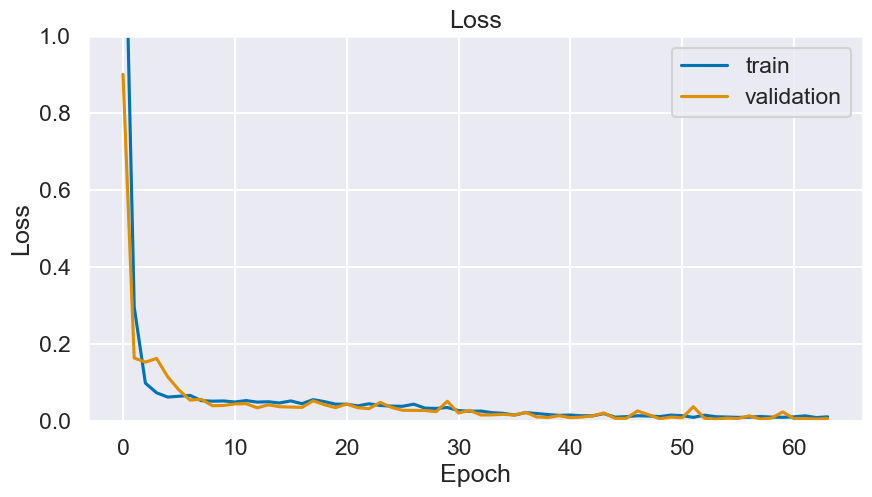

In [10]:
history = best_model.history

sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='train')
plt.plot(history['val_0_mse'], label='validation')
plt.ylim(0, 1)
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

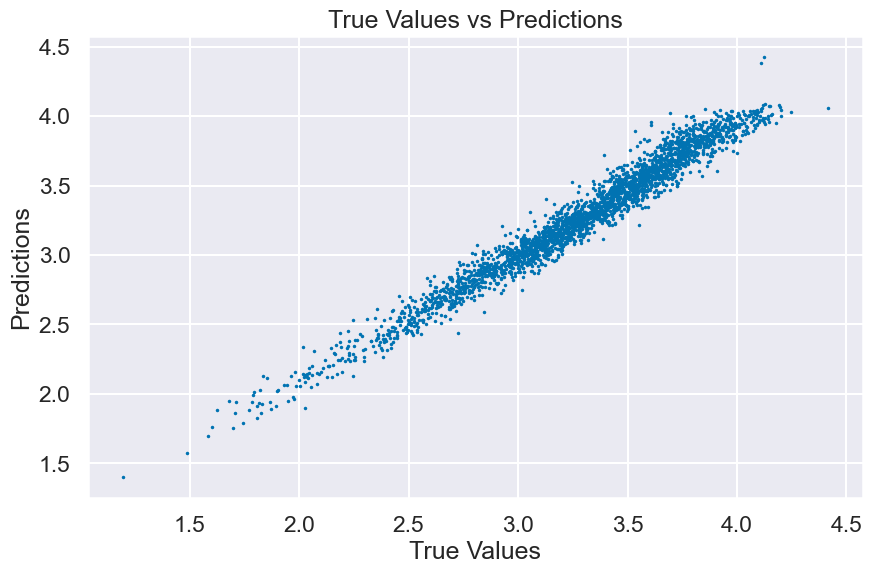

In [8]:
sns.set_style('darkgrid')
sns.set_context('talk')
sns.set_palette('colorblind')
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, preds, s=1)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.show()

In [9]:
# Get the training and validation losses
train_losses = history['loss']
valid_losses = history['val_0_mse']

train_array = np.array(train_losses)
valid_array = np.array(valid_losses)

# create dataframe
df = pd.DataFrame({'training loss': train_array, 'validation loss': valid_array})

df.to_csv('tabularML/training/loss.csv', index=False, header=True)